<a href="https://colab.research.google.com/github/Abimbola-ai/Blood-Spectorscopy/blob/main/Data_Preparation_Blood_Spectroscopy_(ML_Models).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
%matplotlib inline
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !ls /content/drive/MyDrive/Data

In [5]:
#!pip install catboost

In [4]:
import warnings

In [6]:
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, StratifiedShuffleSplit, GroupKFold
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [7]:
#load Datasets

maindir = "/content/drive/MyDrive/Data" # Directory with your files
train = maindir+"/Updated_Train.csv"
test =  maindir+"/Updated_Test.csv"
ss =  maindir+"/Updated_Sample_Submission.csv"
test_trimmed = maindir+"/Updated_Test_trimmed.csv"

In [8]:
#Load additional datasets

# add = maindir+"Low_STD_Data"

# add_std = maindir+"Other_STD_Data"

# os.listdir(add)

hdl_add_lowstd = maindir + '/Exports_hdl_rows_162_full.csv'

hdl_add_std = maindir + '/Exports_hdl_rows_483_full.csv'

hgb_add_lowstd = maindir + '/Export_hgb_rows_965_full.csv'

hgb_add_std = maindir + '/Exports_hgb_rows_2457_full.csv'

ldl_add_lowstd = maindir + '/Exports_ldl_rows_135_full.csv'

ldl_add_std = maindir + '/Exports_ldl_rows_410_full.csv'

In [9]:
#Load spectra absorbance coefficients from research

spectra_hgb = maindir+"/Spectra_hgb.csv"

spectra_gluc = maindir+"/Spectra_gluc.csv"

spectra_sknfatbl = maindir+"/Spectra_skinfatblood.csv"

spectra_chl = maindir+"/Spectra_chl.csv"

## DATA OVERVIEW

The goal of the competition is use the absorbances which is spectrum data to predict the hdl_cholesterol, hemoglobin and ldl_cholestorl level. These can either be low, ok or high. The absorbance spectrum has 170 values over the entire frequency range. In the dataset with labels trim, the edges of the absorbance spectrum have been trimmed by Bloods-ai because they believed the edges are noisy. 

Each measurement actually contains, 60 scans so a lot of the data will actually just be scans of the same measurement. It is important to ensure the model doesn't overfit. The plan is to collect and add more data while the competition is running.

**Train Data**

In [10]:
train = pd.read_csv(train, index_col=0)
train.head()

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,absorbance39,...,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,id,std,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,donation_id
0,0.520883,0.528200,0.529795,0.537382,0.540265,0.546260,0.550882,0.558865,0.571352,0.585775,0.600688,0.612949,0.617855,0.621710,0.622049,0.623373,0.620610,0.619479,0.616463,0.612414,0.609885,0.605408,0.602115,0.597710,0.593485,0.592332,0.588680,0.587396,0.585577,0.585244,0.583597,0.584460,0.584548,0.586147,0.589067,0.591360,0.595636,0.599054,0.602856,0.607817,...,1.468505,1.454910,1.434286,1.443249,1.417403,1.418581,1.403326,1.395943,1.386288,1.381532,1.372256,1.367083,1.362999,1.353013,1.345374,1.341283,1.323804,1.331071,1.332295,1.328928,1.309800,1.328064,1.329464,1.314664,1.313583,1.313329,1.312243,1.310330,1.353629,1.336609,1.319344,1.278294,0,0.0026,39.27,44.17,low,ok,high,2250
1,0.529109,0.534852,0.541075,0.544269,0.546594,0.555183,0.561367,0.567637,0.582427,0.595801,0.608619,0.619217,0.625162,0.627111,0.629326,0.628116,0.627815,0.623644,0.620762,0.617781,0.613032,0.610404,0.605528,0.602216,0.598417,0.595489,0.593692,0.591697,0.590110,0.589316,0.589131,0.587455,0.589060,0.589305,0.591252,0.594853,0.598545,0.601338,0.605673,0.610725,...,1.477741,1.457003,1.445143,1.439036,1.434363,1.422782,1.408831,1.405730,1.394905,1.386579,1.373887,1.376208,1.360633,1.358802,1.353009,1.344997,1.332883,1.324965,1.339512,1.336343,1.322957,1.311612,1.316437,1.316180,1.316063,1.320698,1.321068,1.286939,1.301804,1.314457,1.282723,1.267465,1,0.0026,39.39,44.09,low,ok,high,2250
2,0.528434,0.532036,0.540413,0.541964,0.549347,0.555902,0.561458,0.567824,0.579568,0.593048,0.607972,0.617558,0.624398,0.626222,0.627771,0.626445,0.623953,0.622616,0.618701,0.615181,0.611624,0.608587,0.605730,0.601288,0.597154,0.595654,0.592535,0.591893,0.589885,0.588528,0.587108,0.586997,0.589043,0.588888,0.591670,0.594962,0.597498,0.600767,0.604963,0.612166,...,1.468838,1.456374,1.450920,1.438182,1.434188,1.427201,1.413866,1.403336,1.404049,1.383698,1.378195,1.374761,1.373550,1.362671,1.350157,1.344038,1.341004,1.335655,1.333660,1.325491,1.335868,1.334114,1.327512,1.339627,1.322394,1.328299,1.311948,1.310330,1.311108,1.283048,1.287730,1.266464,2,0.0026,39.50,44.00,low,ok,high,2250
3,0.530528,0.531880,0.539558,0.542433,0.549097,0.556224,0.561398,0.566963,0.577525,0.591982,0.607109,0.616252,0.622437,0.625715,0.626799,0.625676,0.625084,0.622652,0.618510,0.614896,0.611060,0.608285,0.603976,0.600319,0.596856,0.594169,0.591334,0.589620,0.589549,0.587194,0.586685,0.587205,0.587368,0.588510,0.592029,0.593472,0.597904,0.601190,0.604864,0.610652,...,1.474065,1.456521,1.456408,1.445327,1.429233,1.422914,1.422161,1.405341,1.403060,1.390475,1.381461,1.370967,1.370843,1.358100,1.362090,1.352020,1.340746,1.345123,1.332574,1.345660,1.349603,1.329325,1.331542,1.347718,1.321111,1.320285,1.303363,1.306762,1.297632,1.314811,1.314408,1.342224,3,0.0026,39.60,43.89,low,ok,high,2250
4,0.527530,0.536424,0.538207,0.541504,0.550546,0.555203,0.560394,0.567352,0.579438,0.592049,0.606031,0.617109,0.624688,0.626810,0.628163,0.627580,0.625115,0.623415

In [11]:
train.columns

Index(['absorbance0', 'absorbance1', 'absorbance2', 'absorbance3',
       'absorbance4', 'absorbance5', 'absorbance6', 'absorbance7',
       'absorbance8', 'absorbance9',
       ...
       'absorbance168', 'absorbance169', 'id', 'std', 'temperature',
       'humidity', 'hdl_cholesterol_human', 'hemoglobin(hgb)_human',
       'cholesterol_ldl_human', 'donation_id'],
      dtype='object', length=178)

In [12]:
train.dtypes

absorbance0              float64
absorbance1              float64
absorbance2              float64
absorbance3              float64
absorbance4              float64
                          ...   
humidity                 float64
hdl_cholesterol_human     object
hemoglobin(hgb)_human     object
cholesterol_ldl_human     object
donation_id                int64
Length: 178, dtype: object

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29160 entries, 0 to 29159
Columns: 178 entries, absorbance0 to donation_id
dtypes: float64(173), int64(2), object(3)
memory usage: 39.8+ MB


In [14]:
train.shape

(29160, 178)

In [15]:
train = train.drop(['id'], axis = 1)

**Investigate how to extract absorbance from additional datasets**

In [16]:
hdl_add_lowstd = pd.read_csv(hdl_add_lowstd)

hgb_add_lowstd = pd.read_csv(hgb_add_lowstd)

ldl_add_lowstd = pd.read_csv(ldl_add_lowstd)

hdl_add_std = pd.read_csv(hdl_add_std)

hgb_add_std = pd.read_csv(hgb_add_std)

ldl_add_std = pd.read_csv(ldl_add_std)

In [17]:
hdl_add_lowstd.head()

,donation_id,scan_number,absorbance,std,temperature,humidity,hdl_cholesterol_human,hdl_cholesterol_value
0,10841,1,0.52281813260482 0.51949219725263 0.5264422548...,0.0056,42.38,45.58,low,42.2
1,10841,2,0.51923144372845 0.52235175972796 0.5229065445...,0.0056,42.48,45.47,low,42.2
2,10841,3,0.51721320908433 0.51849578207502 0.5245591625...,0.0056,42.58,45.37,low,42.2
3,10841,4,0.52022670958475 0.52037868958736 0.5269751029...,0.0056,42.68,45.32,low,42.2
4,10841,5,0.51708666137411 0.52161464343642 0.5267039231...,0.0056,42.75,45.21,low,42.2


In [18]:
hdl_add_lowstd['absorbance']  = hdl_add_lowstd['absorbance'].apply(lambda x : x.replace('  ', " ").strip())
hgb_add_lowstd['absorbance']  = hgb_add_lowstd['absorbance'].apply(lambda x : x.replace('  ', " ").strip())
ldl_add_lowstd['absorbance']  = ldl_add_lowstd['absorbance'].apply(lambda x : x.replace('  ', " ").strip())

hdl_add_std['absorbance']  = hdl_add_std['absorbance'].apply(lambda x : x.replace('  ', " ").strip())
hgb_add_std['absorbance']  = hgb_add_std['absorbance'].apply(lambda x : x.replace('  ', " ").strip())
ldl_add_std['absorbance']  = ldl_add_std['absorbance'].apply(lambda x : x.replace('  ', " ").strip())

In [19]:
hdl_add_lowstd['abs']  = hdl_add_lowstd['absorbance'].apply(lambda x : x.split(' '))
hgb_add_lowstd['abs']  = hgb_add_lowstd['absorbance'].apply(lambda x : x.split(' '))
ldl_add_lowstd['abs']  = ldl_add_lowstd['absorbance'].apply(lambda x : x.split(' '))

hdl_add_std['abs']  = hdl_add_std['absorbance'].apply(lambda x : x.split(' '))
hgb_add_std['abs']  = hgb_add_std['absorbance'].apply(lambda x : x.split(' '))
ldl_add_std['abs']  = ldl_add_std['absorbance'].apply(lambda x : x.split(' '))

In [20]:
hdl_add_lowstd['str_abs']  = hdl_add_lowstd['abs'].apply(lambda x : 1 if "" in x else 0)
hgb_add_lowstd['str_abs']  = hgb_add_lowstd['abs'].apply(lambda x :  1 if "" in x else 0)
ldl_add_lowstd['str_abs']  = ldl_add_lowstd['abs'].apply(lambda x :  1 if "" in x else 0)

hdl_add_std['str_abs']  = hdl_add_std['abs'].apply(lambda x :  1 if "" in x else 0)
hgb_add_std['str_abs']  = hgb_add_std['abs'].apply(lambda x :  1 if "" in x else 0)
ldl_add_std['str_abs']  = ldl_add_std['abs'].apply(lambda x :  1 if "" in x else 0)

In [22]:
hdl_add_lowstd.head()

,donation_id,scan_number,absorbance,std,temperature,humidity,hdl_cholesterol_human,hdl_cholesterol_value,abs,str_abs
0,10841,1,0.52281813260482 0.51949219725263 0.5264422548...,0.0056,42.38,45.58,low,42.2,"[0.52281813260482, 0.51949219725263, 0.5264422...",0
1,10841,2,0.51923144372845 0.52235175972796 0.5229065445...,0.0056,42.48,45.47,low,42.2,"[0.51923144372845, 0.52235175972796, 0.5229065...",0
2,10841,3,0.51721320908433 0.51849578207502 0.5245591625...,0.0056,42.58,45.37,low,42.2,"[0.51721320908433, 0.51849578207502, 0.5245591...",0
3,10841,4,0.52022670958475 0.52037868958736 0.5269751029...,0.0056,42.68,45.32,low,42.2,"[0.52022670958475, 0.52037868958736, 0.5269751...",0
4,10841,5,0.51708666137411 0.52161464343642 0.5267039231...,0.0056,42.75,45.21,low,42.2,"[0.51708666137411, 0.52161464343642, 0.5267039...",0


In [23]:
# Check if string is present
print(hdl_add_lowstd['str_abs'].sum())
print(ldl_add_lowstd['str_abs'].sum())
print(hdl_add_std['str_abs'].sum())
print(ldl_add_std['str_abs'].sum())

0
0
0
0


**Test Data**

In [24]:
test = pd.read_csv(test)
test.head()

,Unnamed: 0,Reading_ID,donation_id,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,...,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,id,std,temperature,humidity
0,0,ID_KWUAQLRM,ID_2982,0.517951,0.520508,0.526852,0.531611,0.536816,0.543828,0.547761,0.554379,0.565622,0.575762,0.590253,0.600692,0.605104,0.608611,0.608169,0.606985,0.606590,0.603814,0.600409,0.597802,0.593389,0.589956,0.585429,0.583659,0.578307,0.574303,0.571248,0.570985,0.568520,0.566437,0.564261,0.563907,0.563427,0.564336,0.565472,0.567827,0.570957,...,1.416794,1.402706,1.391447,1.385020,1.373256,1.362781,1.345200,1.341810,1.333717,1.328438,1.313325,1.305895,1.293996,1.292892,1.285608,1.275789,1.267682,1.263906,1.259461,1.249615,1.244618,1.242537,1.238426,1.233983,1.235212,1.234433,1.234971,1.223950,1.235415,1.234605,1.226695,1.210430,1.214422,1.200332,1.198297,1.248182,0,0.0027,37.09,27.22
1,1,ID_FN8SIVJJ,ID_2982,0.517839,0.522367,0.525186,0.534661,0.541900,0.546180,0.551687,0.556753,0.566446,0.578208,0.591039,0.601620,0.605895,0.609568,0.610188,0.608635,0.607716,0.606237,0.601746,0.597047,0.594703,0.591059,0.587887,0.582815,0.578746,0.576693,0.573624,0.571268,0.569092,0.567672,0.565814,0.564862,0.564965,0.565536,0.565475,0.567822,0.571052,...,1.417710,1.406884,1.395073,1.387243,1.377109,1.362596,1.350712,1.343471,1.334255,1.320115,1.316767,1.305150,1.289700,1.286014,1.284353,1.274027,1.274710,1.263676,1.255490,1.256831,1.246188,1.236320,1.242136,1.234657,1.233898,1.234317,1.232710,1.238981,1.237033,1.237152,1.219627,1.216220,1.191416,1.202515,1.211942,1.242939,1,0.0027,37.20,27.17
2,2,ID_CI4TQCHI,ID_2982,0.517702,0.522018,0.527237,0.534374,0.541155,0.547152,0.549837,0.557513,0.566793,0.580574,0.592258,0.601226,0.608085,0.611143,0.611085,0.608700,0.608647,0.605048,0.601668,0.598030,0.595072,0.591417,0.587822,0.584160,0.579395,0.576524,0.574158,0.572215,0.569473,0.566740,0.565881,0.565431,0.565380,0.565508,0.566487,0.568591,0.570932,...,1.414933,1.405205,1.395040,1.381880,1.377176,1.360407,1.350644,1.368027,1.338249,1.322779,1.313343,1.300640,1.295481,1.286947,1.283352,1.276702,1.270998,1.262507,1.259525,1.253063,1.247183,1.245595,1.248910,1.239302,1.236558,1.237110,1.239622,1.228925,1.240135,1.238346,1.237193,1.208477,1.208721,1.187810,1.209599,1.175631,2,0.0027,37.30,27.07
3,3,ID_URJMKNU7,ID_2982,0.525008,0.527439,0.536871,0.539636,0.546555,0.553183,0.558826,0.563549,0.575675,0.587214,0.597155,0.606784,0.612443,0.615604,0.616249,0.615097,0.614963,0.611250,0.608559,0.603462,0.599570,0.597532,0.593608,0.588978,0.584560,0.581973,0.578872,0.576858,0.573706,0.571340,0.570279,0.570198,0.568850,0.569583,0.570136,0.571026,0.574510,...,1.417360,1.403515,1.401420,1.382891,1.377412,1.357813,1.352627,1.344537,1.334463,1.323303,1.313057,1.304806,1.299465,1.296792,1.286711,1.273948,1.272122,1.260676,1.255276,1.257032,1.244043,1.246127,1.238651,1.236244,1.243770,1.237752,1.229684,1.228355,1.234852,1.220159,1.218532,1.185708,1.196750,1.222484,1.177406,1.198399,3,0.0027,37.38,26.98
4,4,ID_HBJH67IS,ID_2982,0.520532,0.522683,0.526842,0.534634,0.539676,0.547488,0.552688,0.558355,0.568959,0.578905,0.591207,0.602236,0.

In [25]:
test.columns

Index(['Unnamed: 0', 'Reading_ID', 'donation_id', 'absorbance0', 'absorbance1',
       'absorbance2', 'absorbance3', 'absorbance4', 'absorbance5',
       'absorbance6',
       ...
       'absorbance164', 'absorbance165', 'absorbance166', 'absorbance167',
       'absorbance168', 'absorbance169', 'id', 'std', 'temperature',
       'humidity'],
      dtype='object', length=177)

In [ ]:
test.dtypes

Unnamed: 0         int64
Reading_ID        object
donation_id       object
absorbance0      float64
absorbance1      float64
                  ...   
absorbance169    float64
id                 int64
std              float64
temperature      float64
humidity         float64
Length: 177, dtype: object

**STD distribution**

In [ ]:
hdl_add_std['std'].describe()

count    28980.000000
mean         0.011148
std          0.006065
min          0.002600
25%          0.006200
50%          0.009800
75%          0.014900
max          0.030000
Name: std, dtype: float64

In [ ]:
hdl_add_lowstd['std'].describe()

count    9720.000000
mean        0.005326
std         0.002058
min         0.002400
25%         0.003700
50%         0.004900
75%         0.006600
max         0.012900
Name: std, dtype: float64

In [ ]:
hgb_add_std['std'].describe()

count    147420.000000
mean          0.012447
std           0.006539
min           0.001900
25%           0.007100
50%           0.011200
75%           0.016600
max           0.030000
Name: std, dtype: float64

In [ ]:
hgb_add_lowstd['std'].describe()

count    57900.000000
mean         0.005939
std          0.002110
min          0.002100
25%          0.004400
50%          0.005500
75%          0.007000
max          0.013000
Name: std, dtype: float64

In [ ]:
ldl_add_std['std'].describe()

count    24600.000000
mean         0.010715
std          0.006104
min          0.002400
25%          0.005700
50%          0.009200
75%          0.014500
max          0.030000
Name: std, dtype: float64

In [ ]:
ldl_add_lowstd['std'].describe()

count    8100.000000
mean        0.005275
std         0.001715
min         0.002600
25%         0.003700
50%         0.005100
75%         0.006600
max         0.008700
Name: std, dtype: float64

In [ ]:
train['std'].describe()

count    29160.000000
mean         0.007525
std          0.004625
min          0.002400
25%          0.004500
50%          0.006100
75%          0.008900
max          0.028700
Name: std, dtype: float64

In [ ]:
test['std'].describe()

count    3660.000000
mean        0.005084
std         0.001303
min         0.002700
25%         0.004200
50%         0.004800
75%         0.005700
max         0.008600
Name: std, dtype: float64

**Test set is on low STD data, creating a seperate holdout set with STD matching test set**

In [ ]:
test.describe()

,Unnamed: 0,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,id,std,temperature,humidity
count,3660.00000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,...,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.00000,3660.000000,3660.000000,3660.000000
mean,1829.50000,0.508946,0.511336,0.515381,0.520707,0.527094,0.535162,0.541422,0.547013,0.555412,0.567684,0.581039,0.593493,0.600429,0.604043,0.606310,0.607045,0.605908,0.603618,0.600689,0.597767,0.594695,0.591777,0.588630,0.585256,0.582069,0.579003,0.576539,0.574583,0.572895,0.571582,0.570766,0.570496,0.570819,0.571919,0.573480,0.575729,0.578521,0.582399,0.586197,...,1.505733,1.492644,1.481080,1.469994,1.459005,1.447770,1.436984,1.425464,1.414765,1.404949,1.397377,1.385057,1.376446,1.368437,1.359927,1.352297,1.345108,1.338084,1.331478,1.325147,1.318795,1.313999,1.309967,1.306387,1.304600,1.303607,1.302961,1.302260,1.299918,1.296119,1.289545,1.283293,1.279753,1.279127,1.294189,1.281969,1829.50000,0.005084,40.710525,32.196145
std,1056.69532,0.039688,0.039758,0.039499,0.040224,0.039958,0.039189,0.039701,0.040120,0.040169,0.040554,0.040753,0.040986,0.041115,0.041184,0.041178,0.040990,0.040606,0.040069,0.039787,0.039585,0.039236,0.039176,0.039055,0.038995,0.039108,0.038967,0.038899,0.039011,0.039031,0.038901,0.038991,0.038978,0.039052,0.039094,0.039174,0.039287,0.039449,0.039711,0.039848,...,0.079160,0.077662,0.076777,0.075637,0.074635,0.073851,0.072829,0.071842,0.071147,0.070319,0.070721,0.068948,0.068499,0.068050,0.067434,0.067160,0.066737,0.066285,0.065780,0.065565,0.065048,0.064834,0.064708,0.064523,0.064665,0.065057,0.065856,0.067431,0.070882,0.076008,0.084409,0.092749,0.099267,0.103620,0.109321,0.105555,1056.69532,0.001303,2.432191,8.270529
min,0.00000,0.410071,0.410529,0.420748,0.423644,0.433348,0.443661,0.452187,0.453846,0.462065,0.475356,0.491083,0.502319,0.511833,0.514823,0.517375,0.519095,0.519198,0.517721,0.515886,0.514086,0.511702,0.508972,0.506571,0.503529,0.500822,0.497616,0.495497,0.493432,0.491785,0.491373,0.489769,0.490113,0.491008,0.491944,0.493966,0.496135,0.498948,0.502518,0.506404,...,1.345422,1.339450,1.327657,1.315236,1.302663,1.294809,1.284519,1.271190,1.260948,1.246949,1.244730,1.229793,1.224673,1.219159,1.210517,1.202688,1.196251,

In [ ]:
train.describe()

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,absorbance39,...,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,std,temperature,humidity,donation_id
count,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,...,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000
mean,0.501233,0.505343,0.509430,0.513951,0.520390,0.527901,0.534790,0.539878,0.547992,0.560161,0.573231,0.584865,0.591764,0.595015,0.597245,0.597476,0.596234,0.593176,0.590128,0.586859,0.583380,0.580590,0.577153,0.573811,0.570559,0.567760,0.565109,0.563297,0.561450,0.560132,0.559385,0.558960,0.559301,0.560660,0.562233,0.564392,0.567547,0.571194,0.575372,0.579341,...,1.490524,1.478711,1.466030,1.454837,1.443866,1.432170,1.421440,1.410438,1.398836,1.388896,1.380949,1.368948,1.359843,1.351792,1.342777,1.335093,1.328423,1.321105,1.314336,1.307740,1.301375,1.296554,1.292324,1.289362,1.286892,1.285190,1.284263,1.282959,1.279894,1.274193,1.264868,1.256808,1.250286,1.247337,1.261093,1.249279,0.007525,41.243166,35.340352,6647.707819
std,0.154276,0.114408,0.108543,0.131905,0.130735,0.127874,0.115413,0.122235,0.120122,0.121974,0.122100,0.122428,0.122420,0.123848,0.120746,0.123876,0.118330,0.124504,0.120742,0.122620,0.126951,0.122032,0.126385,0.122497,0.127048,0.121386,0.123169,0.121251,0.124350,0.123667,0.123990,0.127588,0.129428,0.122728,0.123987,0.128728,0.122952,0.127169,0.120845,0.123935,...,0.151301,0.142372,0.142234,0.140698,0.141328,0.143853,0.141736,0.137787,0.139983,0.137170,0.143694,0.135703,0.142351,0.137819,0.144527,0.145659,0.136522,0.137635,0.138376,0.137786,0.140827,0.142068,0.141325,0.132295,0.133350,0.142949,0.140709,0.138222,0.134886,0.134621,0.145471,0.147095,0.157714,0.165125,0.172043,0.142374,0.004625,2.833117,8.700879,3036.003039
min,-2.793790,-1.875939,-1.733555,-2.270881,-2.239499,-2.172958,-1.870428,-2.021362,-1.963416,-1.990968,-1.979389,-1.974791,-1.966305,-1.994694,-1.919333,-1.992345,-1.866250,-2.014556,-1.931571,-1.978287,-2.082679,-1.972898,-2.078091,-1.990606,-2.099514,-1.971445,-2.015786,-1.972720,-2.045393,-2.031182,-2.039416,-2.122756,-2.163846,-2.007071,-2.035230,-2.141747,-2.004040,-2.096984,-1.944085,-2.011826,...,-1.345875,-1.147125,-

**Train set has diverse humidity and temperature ranges, test set range is lower.**

**ss**

In [ ]:
ss = pd.read_csv(ss)
ss.head()

,Unnamed: 0,Donation_ID,target
0,0,ID_1961_cholesterol_ldl_human,ok
1,1,ID_1961_hdl_cholesterol_human,ok
2,2,ID_1961_hemoglobin(hgb)_human,ok
3,3,ID_2067_cholesterol_ldl_human,ok
4,4,ID_2067_hdl_cholesterol_human,ok


**Spectra Data**

In [ ]:
spectra_gluc = pd.read_csv(spectra_gluc)
spectra_gluc.head()

,Glucose,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(X) Wavelength,(Y)Absorbance Coefficient (cm-1),NaN,NaN,NaN,NaN,NaN
1,900,0,NaN,NaN,NaN,NaN,NaN
2,904.733704,0,NaN,NaN,NaN,NaN,NaN
3,909.467468,0,NaN,NaN,NaN,NaN,NaN
4,914.201172,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
spectra_hgb = pd.read_csv(spectra_hgb)
spectra_hgb.head()

,Hb,Unnamed: 1,Unnamed: 2,HbO2,Unnamed: 4
0,(X) Wavelength,(Y)Absorbance Coefficient (cm-1),NaN,(X) Wavelength,(Y)Absorbance Coefficient (cm-1)
1,900,4.014902471,NaN,900,6.432784461
2,904.733704,4.138519444,NaN,904.733704,6.432784461
3,909.467468,4.163159021,NaN,909.467468,6.432784461
4,914.201172,4.163159021,NaN,914.201172,6.432784461


In [ ]:
spectra_sknfatbl = pd.read_csv(spectra_sknfatbl)
spectra_sknfatbl.head()

,Skin,Unnamed: 1,Unnamed: 2,Fat,Unnamed: 4,Unnamed: 5,Deoxygenated whole blood,Unnamed: 7
0,(X) Wavelength,(Y)Absorbance Coefficient (cm-1),NaN,(X) Wavelength,(Y)Absorbance Coefficient (cm-1),NaN,(X) Wavelength,(Y)Absorbance Coefficient (cm-1)
1,900,4.174649324,NaN,900,5.995811903,NaN,900,18.17079798
2,904.733704,4.143239133,NaN,904.733704,5.995811903,NaN,904.733704,18.17079798
3,909.467468,4.143239133,NaN,909.467468,5.995811903,NaN,909.467468,18.17079798
4,914.201172,4.143239133,NaN,914.201172,5.995811903,NaN,914.201172,18.17079798


In [ ]:
spectra_chl = pd.read_csv(spectra_chl)
spectra_chl.head()

,Cholesterol,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(X) Wavelength,(Y)Absorbance Coefficient (cm-1),NaN,NaN,NaN,NaN,NaN
1,900,0.176311646,NaN,NaN,NaN,NaN,NaN
2,904.733704,0.176035801,NaN,NaN,NaN,NaN,NaN
3,909.467468,0.175760387,NaN,NaN,NaN,NaN,NaN
4,914.201172,0.175485404,NaN,NaN,NaN,NaN,NaN


**Number of unique user donations**

In [ ]:
train['donation_id'].nunique()

486

In [ ]:
train['donation_id'].value_counts()

2250     60
10224    60
9368     60
9369     60
9370     60
         ..
6387     60
7676     60
2194     60
2519     60
1994     60
Name: donation_id, Length: 486, dtype: int64

## EDA & DATA PREPROCESSING

In [ ]:
train.describe()

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,absorbance39,...,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,std,temperature,humidity,donation_id
count,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,...,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000,29160.000000
mean,0.501233,0.505343,0.509430,0.513951,0.520390,0.527901,0.534790,0.539878,0.547992,0.560161,0.573231,0.584865,0.591764,0.595015,0.597245,0.597476,0.596234,0.593176,0.590128,0.586859,0.583380,0.580590,0.577153,0.573811,0.570559,0.567760,0.565109,0.563297,0.561450,0.560132,0.559385,0.558960,0.559301,0.560660,0.562233,0.564392,0.567547,0.571194,0.575372,0.579341,...,1.490524,1.478711,1.466030,1.454837,1.443866,1.432170,1.421440,1.410438,1.398836,1.388896,1.380949,1.368948,1.359843,1.351792,1.342777,1.335093,1.328423,1.321105,1.314336,1.307740,1.301375,1.296554,1.292324,1.289362,1.286892,1.285190,1.284263,1.282959,1.279894,1.274193,1.264868,1.256808,1.250286,1.247337,1.261093,1.249279,0.007525,41.243166,35.340352,6647.707819
std,0.154276,0.114408,0.108543,0.131905,0.130735,0.127874,0.115413,0.122235,0.120122,0.121974,0.122100,0.122428,0.122420,0.123848,0.120746,0.123876,0.118330,0.124504,0.120742,0.122620,0.126951,0.122032,0.126385,0.122497,0.127048,0.121386,0.123169,0.121251,0.124350,0.123667,0.123990,0.127588,0.129428,0.122728,0.123987,0.128728,0.122952,0.127169,0.120845,0.123935,...,0.151301,0.142372,0.142234,0.140698,0.141328,0.143853,0.141736,0.137787,0.139983,0.137170,0.143694,0.135703,0.142351,0.137819,0.144527,0.145659,0.136522,0.137635,0.138376,0.137786,0.140827,0.142068,0.141325,0.132295,0.133350,0.142949,0.140709,0.138222,0.134886,0.134621,0.145471,0.147095,0.157714,0.165125,0.172043,0.142374,0.004625,2.833117,8.700879,3036.003039
min,-2.793790,-1.875939,-1.733555,-2.270881,-2.239499,-2.172958,-1.870428,-2.021362,-1.963416,-1.990968,-1.979389,-1.974791,-1.966305,-1.994694,-1.919333,-1.992345,-1.866250,-2.014556,-1.931571,-1.978287,-2.082679,-1.972898,-2.078091,-1.990606,-2.099514,-1.971445,-2.015786,-1.972720,-2.045393,-2.031182,-2.039416,-2.122756,-2.163846,-2.007071,-2.035230,-2.141747,-2.004040,-2.096984,-1.944085,-2.011826,...,-1.345875,-1.147125,-

**Spectral data is represented using wavelengths, absorbance values are equivalent wavelength values. Create a dictionary mapping for easy identification**

In [ ]:
wavelengths = list(spectra_gluc[1:]['Glucose'])

absorbance_dict = dict()

val = 0

for wave in wavelengths:
    
    absorbance_dict[f'absorbance{val}'] = wave
    
    val += 1

In [ ]:
list(absorbance_dict.keys())

['absorbance0',
 'absorbance1',
 'absorbance2',
 'absorbance3',
 'absorbance4',
 'absorbance5',
 'absorbance6',
 'absorbance7',
 'absorbance8',
 'absorbance9',
 'absorbance10',
 'absorbance11',
 'absorbance12',
 'absorbance13',
 'absorbance14',
 'absorbance15',
 'absorbance16',
 'absorbance17',
 'absorbance18',
 'absorbance19',
 'absorbance20',
 'absorbance21',
 'absorbance22',
 'absorbance23',
 'absorbance24',
 'absorbance25',
 'absorbance26',
 'absorbance27',
 'absorbance28',
 'absorbance29',
 'absorbance30',
 'absorbance31',
 'absorbance32',
 'absorbance33',
 'absorbance34',
 'absorbance35',
 'absorbance36',
 'absorbance37',
 'absorbance38',
 'absorbance39',
 'absorbance40',
 'absorbance41',
 'absorbance42',
 'absorbance43',
 'absorbance44',
 'absorbance45',
 'absorbance46',
 'absorbance47',
 'absorbance48',
 'absorbance49',
 'absorbance50',
 'absorbance51',
 'absorbance52',
 'absorbance53',
 'absorbance54',
 'absorbance55',
 'absorbance56',
 'absorbance57',
 'absorbance58',
 'absor

In [ ]:
#Extracting addtional data into absorbances columns

def extract_add_data(df, index):
    
    abs_values = df.split(' ')
    
     
    
    try:
        abs_val = abs_values[index]
        
        abs_val = float(abs_val)
        
    except:
        
        abs_val = np.nan
    
    
    return abs_val
    
    

In [ ]:
for i in tqdm(range(0, 170)):
    
    hdl_add_lowstd[f'absorbance{i}'] = hdl_add_lowstd['absorbance'].apply(extract_add_data, index = i)
    
    hgb_add_lowstd[f'absorbance{i}'] = hgb_add_lowstd['absorbance'].apply(extract_add_data, index = i)
    
    ldl_add_lowstd[f'absorbance{i}'] = ldl_add_lowstd['absorbance'].apply(extract_add_data, index = i)
    
    
    hdl_add_std[f'absorbance{i}'] = hdl_add_std['absorbance'].apply(extract_add_data, index = i)
    
    hgb_add_std[f'absorbance{i}'] = hgb_add_std['absorbance'].apply(extract_add_data, index = i)
    
    ldl_add_std[f'absorbance{i}'] = ldl_add_std['absorbance'].apply(extract_add_data, index = i)

 56%|█████▌    | 95/170 [04:07<03:03,  2.45s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

In [ ]:
hgb_add_std.isnull().sum()

donation_id        0
scan_number        0
absorbance         0
std                0
temperature        0
                ... 
absorbance165      0
absorbance166      0
absorbance167      0
absorbance168    180
absorbance169    180
Length: 180, dtype: int64

In [ ]:
hdl_add_std.isnull().sum()

donation_id        0
scan_number        0
absorbance         0
std                0
temperature        0
                ... 
absorbance165      0
absorbance166      0
absorbance167      0
absorbance168    120
absorbance169    120
Length: 180, dtype: int64

In [ ]:
ldl_add_std.isnull().sum()

donation_id        0
scan_number        0
absorbance         0
std                0
temperature        0
                ... 
absorbance165      0
absorbance166      0
absorbance167      0
absorbance168    120
absorbance169    120
Length: 180, dtype: int64

In [ ]:
hgb_add_lowstd.isnull().sum()

donation_id        0
scan_number        0
absorbance         0
std                0
temperature        0
                ... 
absorbance165      0
absorbance166      0
absorbance167     60
absorbance168    180
absorbance169    240
Length: 180, dtype: int64

In [ ]:
hdl_add_lowstd.isnull().sum()

donation_id      0
scan_number      0
absorbance       0
std              0
temperature      0
                ..
absorbance165    0
absorbance166    0
absorbance167    0
absorbance168    0
absorbance169    0
Length: 180, dtype: int64

In [ ]:
ldl_add_lowstd.isnull().sum()

donation_id       0
scan_number       0
absorbance        0
std               0
temperature       0
                 ..
absorbance165     0
absorbance166     0
absorbance167     0
absorbance168    60
absorbance169    60
Length: 180, dtype: int64

**Additional data has null absorbances, not certain which of the absorbances is intended to be null. Some space os left between some absorbances in the string. I used all the available absorbances to fill the earlier ones and later ones are null when not up to 170. Possibly validate data with just train dataframe. Train with additional data only**

In [ ]:
train.columns

Index(['absorbance0', 'absorbance1', 'absorbance2', 'absorbance3',
       'absorbance4', 'absorbance5', 'absorbance6', 'absorbance7',
       'absorbance8', 'absorbance9',
       ...
       'absorbance167', 'absorbance168', 'absorbance169', 'std', 'temperature',
       'humidity', 'hdl_cholesterol_human', 'hemoglobin(hgb)_human',
       'cholesterol_ldl_human', 'donation_id'],
      dtype='object', length=177)

In [ ]:
hdl_add_std.columns

Index(['donation_id', 'scan_number', 'absorbance', 'std', 'temperature',
       'humidity', 'hdl_cholesterol_human', 'hdl_cholesterol_value', 'abs',
       'str_abs',
       ...
       'absorbance160', 'absorbance161', 'absorbance162', 'absorbance163',
       'absorbance164', 'absorbance165', 'absorbance166', 'absorbance167',
       'absorbance168', 'absorbance169'],
      dtype='object', length=180)

In [ ]:
hdl_add_std[train.columns.drop(['hemoglobin(hgb)_human', 'cholesterol_ldl_human'])]

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,absorbance39,...,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,std,temperature,humidity,hdl_cholesterol_human,donation_id
0,0.462178,0.462944,0.464227,0.469669,0.472651,0.476960,0.481944,0.487505,0.497185,0.508475,0.519577,0.528948,0.535470,0.538555,0.540428,0.538719,0.538971,0.536787,0.534959,0.531327,0.528904,0.527730,0.522744,0.518779,0.513931,0.509429,0.506065,0.503667,0.501000,0.499116,0.497692,0.496570,0.496119,0.496306,0.497794,0.499326,0.501267,0.503584,0.506621,0.509873,...,1.334445,1.320379,1.306265,1.302035,1.287795,1.277945,1.265819,1.252941,1.236984,1.242337,1.228986,1.223462,1.208107,1.201180,1.195243,1.188727,1.184901,1.174525,1.168327,1.163948,1.162667,1.156576,1.159775,1.151892,1.153629,1.151953,1.160587,1.148302,1.162260,1.171134,1.173295,1.167422,1.188758,1.194984,1.197200,0.013,33.60,52.51,low,11966
1,0.459166,0.458598,0.457791,0.465418,0.468679,0.472225,0.477586,0.483779,0.492655,0.503743,0.516180,0.527150,0.532310,0.537849,0.538625,0.537969,0.536235,0.535017,0.532900,0.529468,0.527966,0.524255,0.521171,0.516336,0.512777,0.508018,0.504687,0.501929,0.500112,0.496935,0.497118,0.496300,0.495359,0.495694,0.497222,0.498706,0.501705,0.503934,0.507765,0.511215,...,1.332137,1.319015,1.306234,1.294912,1.287950,1.275543,1.269917,1.252988,1.247365,1.239310,1.227067,1.220951,1.209616,1.207345,1.194800,1.192895,1.184938,1.178310,1.176847,1.171896,1.160232,1.155645,1.152834,1.151342,1.150060,1.154422,1.149962,1.164822,1.166097,1.170071,1.186744,1.167936,1.205665,1.175499,1.171809,0.013,33.75,52.35,low,11966
2,0.476732,0.480364,0.477951,0.483665,0.485520,0.492748,0.496361,0.502396,0.512053,0.522516,0.532342,0.542315,0.548390,0.552082,0.553274,0.552263,0.551582,0.549016,0.547029,0.543677,0.542303,0.539034,0.535404,0.530521,0.525932,0.521695,0.519176,0.515318,0.513491,0.510026,0.508261,0.507473,0.506832,0.507518,0.507487,0.509373,0.510500,0.513778,0.516419,0.519609,...,1.321095,1.309011,1.292679,1.283503,1.281099,1.268217,1.262985,1.252736,1.239864,1.230272,1.220973,1.215856,1.205947,1.198181,1.196218,1.192383,1.175982,1.173875,1.170865,1.167220,1.158414,1.154456,1.156677,1.148106,1.146846,1.145613,1.152125,1.160085,1.148437,1.159116,1.173176,1.170293,1.193216,1.172818,1.151251,0.013,33.87,52.24,low,11966
3,0.445759,0.445833,0.449111,0.449868,0.454603,0.459663,0.466544,0.471227,0.481840,0.492401,0.505779,0.515557,0.521910,0.526497,0.528068,0.526881,0.527048,0.525079,0.521805,0.519076,0.517084,0.515052,0.510707,0.507714,0.501478,0.498862,0.495991,0.493687,0.492065,0.489634,0.488636,0.489237,0.488372,0.489169,0.490975,0.494237,0.496769,0.499458,0.502797,0.506361,...,1.302566,1.294089,1.282427,1.271628,1.265476,1.253350,1.243511,1.235659,1.230014,1.223789,1.206015,1.199472,1.191933,1.186439,1.183242,1.172813,1.167206,1.154046,1.153912,1.149630,1.141608,1.140024,1.144698,1.136597,1.139749,1.135727,1.137149,1.146144,1.147552,1.143274,1.141747,1.168377,1.194581,1.146230,1.179854,0.013,34.00,52.23,low,11966
4,0.448478,0.449715,0.454326,0.457546,0.459299,0.463268,0.470947,0.475343,0.484919,0.496428,0.508855

In [ ]:
hdl_add_std = hdl_add_std[train.columns.drop(['hemoglobin(hgb)_human', 'cholesterol_ldl_human'])]

hdl_add_lowstd = hdl_add_lowstd[train.columns.drop(['hemoglobin(hgb)_human', 'cholesterol_ldl_human'])]



hgb_add_std = hgb_add_std[train.columns.drop(['hdl_cholesterol_human', 'cholesterol_ldl_human'])]

hgb_add_lowstd = hgb_add_lowstd[train.columns.drop(['hdl_cholesterol_human', 'cholesterol_ldl_human'])]



ldl_add_std = ldl_add_std[train.columns.drop(['hdl_cholesterol_human', 'hemoglobin(hgb)_human'])]

ldl_add_lowstd = ldl_add_lowstd[train.columns.drop(['hdl_cholesterol_human', 'hemoglobin(hgb)_human'])]



In [ ]:
hdl_add_std.columns

Index(['absorbance0', 'absorbance1', 'absorbance2', 'absorbance3',
       'absorbance4', 'absorbance5', 'absorbance6', 'absorbance7',
       'absorbance8', 'absorbance9',
       ...
       'absorbance165', 'absorbance166', 'absorbance167', 'absorbance168',
       'absorbance169', 'std', 'temperature', 'humidity',
       'hdl_cholesterol_human', 'donation_id'],
      dtype='object', length=175)

In [ ]:
merge_cols = list(absorbance_dict.keys())


merge_cols.extend(['donation_id', 'humidity', 'std', 'temperature'])

In [ ]:
merge_cols

['absorbance0',
 'absorbance1',
 'absorbance2',
 'absorbance3',
 'absorbance4',
 'absorbance5',
 'absorbance6',
 'absorbance7',
 'absorbance8',
 'absorbance9',
 'absorbance10',
 'absorbance11',
 'absorbance12',
 'absorbance13',
 'absorbance14',
 'absorbance15',
 'absorbance16',
 'absorbance17',
 'absorbance18',
 'absorbance19',
 'absorbance20',
 'absorbance21',
 'absorbance22',
 'absorbance23',
 'absorbance24',
 'absorbance25',
 'absorbance26',
 'absorbance27',
 'absorbance28',
 'absorbance29',
 'absorbance30',
 'absorbance31',
 'absorbance32',
 'absorbance33',
 'absorbance34',
 'absorbance35',
 'absorbance36',
 'absorbance37',
 'absorbance38',
 'absorbance39',
 'absorbance40',
 'absorbance41',
 'absorbance42',
 'absorbance43',
 'absorbance44',
 'absorbance45',
 'absorbance46',
 'absorbance47',
 'absorbance48',
 'absorbance49',
 'absorbance50',
 'absorbance51',
 'absorbance52',
 'absorbance53',
 'absorbance54',
 'absorbance55',
 'absorbance56',
 'absorbance57',
 'absorbance58',
 'absor

In [ ]:
hdl_concat = pd.concat([hdl_add_std, hdl_add_lowstd])

hgb_concat = pd.concat([hgb_add_std, hgb_add_lowstd])

ldl_concat = pd.concat([ldl_add_std, ldl_add_lowstd])

add_data = hdl_concat.merge(hgb_concat, on = merge_cols, how = 'outer')

add_data = add_data.merge(ldl_concat, on = merge_cols, how = 'left')

In [ ]:
add_data.columns

Index(['absorbance0', 'absorbance1', 'absorbance2', 'absorbance3',
       'absorbance4', 'absorbance5', 'absorbance6', 'absorbance7',
       'absorbance8', 'absorbance9',
       ...
       'absorbance167', 'absorbance168', 'absorbance169', 'std', 'temperature',
       'humidity', 'hdl_cholesterol_human', 'donation_id',
       'hemoglobin(hgb)_human', 'cholesterol_ldl_human'],
      dtype='object', length=177)

**Merge additional data on donation id**

In [ ]:
train['tag'] = 'original_train'

In [ ]:
train = pd.concat([train, add_data])

In [ ]:
train.describe()

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,absorbance39,...,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,std,temperature,humidity,donation_id
count,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,...,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272280.000000,272220.000000,271800.000000,271740.000000,272280.000000,272280.000000,272280.000000,272280.000000
mean,0.500809,0.502612,0.505531,0.510278,0.516441,0.523460,0.529206,0.534707,0.542323,0.553328,0.566525,0.577803,0.584394,0.587517,0.588861,0.588867,0.587407,0.584603,0.581849,0.578501,0.575225,0.572217,0.568889,0.565409,0.562115,0.558872,0.556716,0.554880,0.553093,0.551437,0.550733,0.550328,0.550534,0.551321,0.552898,0.554752,0.557718,0.560823,0.564803,0.568481,...,1.497674,1.484733,1.471303,1.459352,1.447783,1.435112,1.423154,1.411618,1.399653,1.388895,1.380348,1.367813,1.358521,1.349639,1.340738,1.332444,1.325190,1.317341,1.310008,1.303551,1.297138,1.291616,1.287547,1.284166,1.281788,1.281449,1.280867,1.281182,1.280789,1.278176,1.271954,1.268309,1.263684,1.263319,1.281270,1.272410,0.010155,42.437299,34.362632,7053.864257
std,0.135124,0.139148,0.148578,0.142709,0.137424,0.136014,0.142063,0.140282,0.139052,0.140716,0.133878,0.137132,0.137144,0.137307,0.138390,0.136606,0.135103,0.139805,0.134043,0.135634,0.139499,0.137820,0.139393,0.134648,0.139593,0.142541,0.137441,0.133589,0.134860,0.140171,0.136975,0.137353,0.137905,0.139889,0.136815,0.141390,0.137607,0.141785,0.135117,0.140778,...,0.161573,0.160263,0.158293,0.158024,0.156866,0.156571,0.160013,0.157037,0.154250,0.154019,0.153731,0.152157,0.151068,0.153359,0.156602,0.150613,0.146873,0.149759,0.151718,0.146913,0.146117,0.151205,0.147380,0.146095,0.153062,0.146242,0.155136,0.153327,0.149411,0.151209,0.190744,0.158759,0.170012,0.158122,0.125130,0.112247,0.006219,3.523198,9.770353,2803.190617
min,-3.354448,-3.203142,-3.026356,-2.722502,-2.584943,-2.284043,-2.781598,-3.039160,-2.522549,-2.621200,-2.303569,-2.565006,-2.309635,-2.401524,-2.658202,-2.515770,-2.286585,-2.546185,-2.324405,-2.285206,-2.531547,-2.484381,-2.398179,-2.328897,-2.474997,-2.513569,-2.466271,-2.201226,-2.261305,-2.520097,-2.410635,-2.305019,-2.457921,-2.627971,-2.46

In [ ]:
train[train['absorbance0'] < 0]

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,absorbance39,...,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,std,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,donation_id,tag
25260,-2.781627,-1.862871,-1.716636,-2.262761,-2.227659,-2.157117,-1.862197,-2.012625,-1.956210,-1.982586,-1.974004,-1.968540,-1.958346,-1.988779,-1.913199,-1.987249,-1.860901,-2.008799,-1.927821,-1.973466,-2.079683,-1.968678,-2.072799,-1.986251,-2.093962,-1.968338,-2.012686,-1.968370,-2.043149,-2.028333,-2.036715,-2.120725,-2.161146,-2.005382,-2.032168,-2.138857,-2.002472,-2.093557,-1.941449,-2.009253,...,-1.194902,-1.285326,-1.259264,-1.180056,-1.264640,-1.216631,-1.385581,-1.210704,-1.404825,-1.296576,-1.479352,-1.517193,-1.307971,-1.354232,-1.374267,-1.370922,-1.461696,-1.496044,-1.488963,-1.253925,-1.292487,-1.528773,-1.459026,-1.379363,-1.278589,-1.231655,-1.431010,-1.359039,-1.565202,-1.687033,-1.776553,-0.944077,0.0058,36.92,33.80,low,ok,high,6824,original_train
25261,-2.783794,-1.865895,-1.719729,-2.261806,-2.227773,-2.158221,-1.863070,-2.013811,-1.956231,-1.983514,-1.972238,-1.969199,-1.959020,-1.989112,-1.914915,-1.988582,-1.861559,-2.010631,-1.927708,-1.973670,-2.080057,-1.968727,-2.073372,-1.988213,-2.096212,-1.968710,-2.011532,-1.969461,-2.043646,-2.029720,-2.037293,-2.120992,-2.161481,-2.005157,-2.032899,-2.138638,-2.001977,-2.093949,-1.944085,-2.009242,...,-1.197788,-1.290379,-1.258572,-1.185859,-1.268233,-1.215053,-1.390248,-1.211922,-1.404756,-1.298097,-1.484253,-1.526593,-1.298800,-1.357221,-1.374396,-1.370420,-1.453125,-1.501093,-1.482095,-1.259472,-1.292393,-1.534427,-1.467235,-1.394265,-1.288813,-1.228880,-1.431212,-1.356149,-1.554726,-1.690885,-1.811098,-0.947684,0.0058,37.01,33.78,low,ok,high,6824,original_train
25262,-2.786715,-1.864707,-1.721986,-2.260991,-2.227944,-2.158372,-1.860445,-2.013123,-1.954717,-1.985162,-1.972860,-1.969073,-1.960883,-1.988948,-1.915639,-1.987194,-1.860309,-2.009833,-1.927010,-1.974592,-2.079920,-1.968453,-2.073161,-1.987647,-2.094722,-1.967816,-2.011588,-1.969721,-2.043835,-2.028329,-2.036377,-2.120448,-2.160755,-2.005252,-2.033219,-2.139207,-2.001332,-2.095189,-1.941389,-2.008988,...,-1.194070,-1.294142,-1.261868,-1.177818,-1.261981,-1.216742,-1.389086,-1.217688,-1.394806,-1.297583,-1.485952,-1.524648,-1.303223,-1.350298,-1.377262,-1.373296,-1.452104,-1.487144,-1.488161,-1.262761,-1.287159,-1.523905,-1.479382,-1.401767,-1.290374,-1.225137,-1.426071,-1.375752,-1.578717,-1.704055,-1.788096,-0.898127,0.0058,37.11,33.78,low,ok,high,6824,original_train
25263,-2.789942,-1.862677,-1.725185,-2.263404,-2.231081,-2.162574,-1.863298,-2.014426,-1.956547,-1.986054,-1.974416,-1.969902,-1.959649,-1.991583,-1.915600,-1.989242,-1.861228,-2.011685,-1.927805,-1.976387,-2.081538,-1.969937,-2.074293,-1.987440,-2.096921,-1.968426,-2.013126,-1.969524,-2.044020,-2.028953,-2.037644,-2.119896,-2.162619,-2.005853,-2.033455,-2.139565,-2.001839,-2.094468,-1.942181,-2.009969,...,-1.187018,-1.287614,-1.252991,-1.183986,-1.261622,-1.206351,-1.394461,-1.213753,-1.394596,-1.297419,-1.480260,-1.519416,-1.307750,-1.341862,-1.374189,-1.366643,-1.455353,-1.4905

In [ ]:
#Delete invalid donation sample

drop_inds = train[train['absorbance0'] < 0].index

train = train.drop(drop_inds)

In [ ]:
train.describe()

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,absorbance39,...,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,std,temperature,humidity,donation_id
count,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,...,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000,271500.000000
mean,0.506698,0.508748,0.512124,0.516604,0.522528,0.529486,0.535496,0.540922,0.548504,0.559583,0.572453,0.583885,0.590485,0.593613,0.595001,0.594922,0.593390,0.590809,0.587787,0.584517,0.581431,0.578341,0.575094,0.571380,0.568321,0.565226,0.562821,0.560800,0.559076,0.557674,0.556821,0.556437,0.556668,0.557545,0.558976,0.561057,0.563834,0.567148,0.570796,0.574746,...,1.503897,1.490938,1.477457,1.465531,1.453938,1.441295,1.429562,1.417890,1.405812,1.395070,1.386528,1.373936,1.364610,1.355861,1.347147,1.338560,1.331117,1.323444,1.316223,1.309518,1.303079,1.297837,1.293569,1.290125,1.288089,1.287404,1.287263,1.287437,1.286801,1.284178,1.279557,1.274403,1.270178,1.268711,1.282644,1.272936,0.010158,42.435110,34.373738,7056.971713
std,0.044799,0.044577,0.044495,0.044430,0.044411,0.044705,0.044653,0.044473,0.044248,0.044156,0.044122,0.044151,0.044181,0.044256,0.044329,0.044371,0.044323,0.044216,0.044148,0.044158,0.044066,0.044031,0.044000,0.044004,0.044050,0.044029,0.044011,0.043981,0.043962,0.043942,0.043894,0.043863,0.043853,0.043830,0.043820,0.043791,0.043858,0.043921,0.043933,0.043989,...,0.092365,0.090554,0.088795,0.087361,0.085996,0.084588,0.083286,0.082063,0.080871,0.079918,0.079271,0.078052,0.077296,0.076625,0.076012,0.075356,0.074829,0.074229,0.073708,0.073281,0.072850,0.072518,0.072269,0.072184,0.072282,0.072651,0.073357,0.074718,0.076859,0.080168,0.085132,0.091523,0.097507,0.102222,0.107535,0.107357,0.006222,3.520368,9.771330,2804.570925
min,0.231888,0.233178,0.239425,0.242022,0.244915,0.251377,0.256958,0.265941,0.275875,0.287785,0.301872,0.318441,0.325600,0.329111,0.331615,0.332044,0.330609,0.330158,0.326903,0.324553,0.321165,0.317876,0.315902,0.312379,0.311793,0.307409,0.306616,0.303126,0.303066,0.301019,0.299696,0.299018,0.299118,0.300105,0.300354,0.302565,0.305482,0.307391,0.3

**Trimmed is done by taking the removing first and last 10 values**

650 nm to 1350 nm is the biological stable range, also range of highest penetration with human skin. Experimentation will be done on different wavelength ranges to determine optimal range. For starter, we will work with the stated wavelength range.

In [ ]:
train['tag_set'] = 'train'
test['tag_set'] = 'test'
all_data = pd.concat([train, test])

In [ ]:
all_data.head()

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,absorbance39,...,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,std,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,donation_id,tag,tag_set,Unnamed: 0,Reading_ID,id
0,0.520883,0.528200,0.529795,0.537382,0.540265,0.546260,0.550882,0.558865,0.571352,0.585775,0.600688,0.612949,0.617855,0.621710,0.622049,0.623373,0.620610,0.619479,0.616463,0.612414,0.609885,0.605408,0.602115,0.597710,0.593485,0.592332,0.588680,0.587396,0.585577,0.585244,0.583597,0.584460,0.584548,0.586147,0.589067,0.591360,0.595636,0.599054,0.602856,0.607817,...,1.417403,1.418581,1.403326,1.395943,1.386288,1.381532,1.372256,1.367083,1.362999,1.353013,1.345374,1.341283,1.323804,1.331071,1.332295,1.328928,1.309800,1.328064,1.329464,1.314664,1.313583,1.313329,1.312243,1.310330,1.353629,1.336609,1.319344,1.278294,0.0026,39.27,44.17,low,ok,high,2250,original_train,train,NaN,NaN,NaN
1,0.529109,0.534852,0.541075,0.544269,0.546594,0.555183,0.561367,0.567637,0.582427,0.595801,0.608619,0.619217,0.625162,0.627111,0.629326,0.628116,0.627815,0.623644,0.620762,0.617781,0.613032,0.610404,0.605528,0.602216,0.598417,0.595489,0.593692,0.591697,0.590110,0.589316,0.589131,0.587455,0.589060,0.589305,0.591252,0.594853,0.598545,0.601338,0.605673,0.610725,...,1.434363,1.422782,1.408831,1.405730,1.394905,1.386579,1.373887,1.376208,1.360633,1.358802,1.353009,1.344997,1.332883,1.324965,1.339512,1.336343,1.322957,1.311612,1.316437,1.316180,1.316063,1.320698,1.321068,1.286939,1.301804,1.314457,1.282723,1.267465,0.0026,39.39,44.09,low,ok,high,2250,original_train,train,NaN,NaN,NaN
2,0.528434,0.532036,0.540413,0.541964,0.549347,0.555902,0.561458,0.567824,0.579568,0.593048,0.607972,0.617558,0.624398,0.626222,0.627771,0.626445,0.623953,0.622616,0.618701,0.615181,0.611624,0.608587,0.605730,0.601288,0.597154,0.595654,0.592535,0.591893,0.589885,0.588528,0.587108,0.586997,0.589043,0.588888,0.591670,0.594962,0.597498,0.600767,0.604963,0.612166,...,1.434188,1.427201,1.413866,1.403336,1.404049,1.383698,1.378195,1.374761,1.373550,1.362671,1.350157,1.344038,1.341004,1.335655,1.333660,1.325491,1.335868,1.334114,1.327512,1.339627,1.322394,1.328299,1.311948,1.310330,1.311108,1.283048,1.287730,1.266464,0.0026,39.50,44.00,low,ok,high,2250,original_train,train,NaN,NaN,NaN
3,0.530528,0.531880,0.539558,0.542433,0.549097,0.556224,0.561398,0.566963,0.577525,0.591982,0.607109,0.616252,0.622437,0.625715,0.626799,0.625676,0.625084,0.622652,0.618510,0.614896,0.611060,0.608285,0.603976,0.600319,0.596856,0.594169,0.591334,0.589620,0.589549,0.587194,0.586685,0.587205,0.587368,0.588510,0.592029,0.593472,0.597904,0.601190,0.604864,0.610652,...,1.429233,1.422914,1.422161,1.405341,1.403060,1.390475,1.381461,1.370967,1.370843,1.358100,1.362090,1.352020,1.340746,1.345123,1.332574,1.345660,1.349603,1.329325,1.331542,1.347718,1.321111,1.320285,1.303363,1.306762,1.297632,1.314811,1.314408,1.342224,0.0026,39.60,43.89,low,ok,high,2250,original_train,train,NaN,NaN,NaN
4,0.527530,0.536424,0.538207,0.541504,0.550546,0.555203,0.560394,0.567352,0.579438,0.592049,0.606031,0.617109,0.624688,0.626810,0.628163,0.627580,0.625115,0.623415,0.619177,0.615396,0.612086,0.609498,0.604

In [ ]:
all_data.tail()

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,absorbance39,...,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,std,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,donation_id,tag,tag_set,Unnamed: 0,Reading_ID,id
3655,0.497070,0.497695,0.502808,0.507090,0.514892,0.521367,0.526767,0.533428,0.543408,0.555254,0.575275,0.586130,0.595294,0.598428,0.602202,0.602773,0.602423,0.600612,0.599134,0.595396,0.592461,0.588193,0.584579,0.579989,0.577405,0.574225,0.571682,0.569005,0.567628,0.564355,0.564599,0.564300,0.564457,0.565850,0.566444,0.567404,0.572339,0.574416,0.577380,0.581190,...,1.473422,1.457182,1.445869,1.438351,1.435618,1.424537,1.411332,1.405034,1.404410,1.394026,1.382925,1.369103,1.369450,1.368412,1.364834,1.352828,1.357255,1.361776,1.349810,1.363796,1.372737,1.371869,1.359282,1.367149,1.374637,1.385400,1.432182,1.317007,0.0086,40.63,36.33,NaN,NaN,NaN,ID_3637,NaN,test,3655.0,ID_HDGHLAEP,3655.0
3656,0.497743,0.500444,0.499285,0.506751,0.513825,0.520425,0.529959,0.534135,0.543648,0.556639,0.574594,0.586575,0.595990,0.599644,0.603106,0.603112,0.603253,0.601545,0.598831,0.595814,0.592052,0.588001,0.583881,0.580274,0.577228,0.574091,0.571711,0.569637,0.566645,0.566320,0.565135,0.564738,0.564100,0.566069,0.566304,0.568799,0.572283,0.574307,0.577386,0.580886,...,1.478349,1.466368,1.459610,1.440381,1.433496,1.420629,1.414092,1.403724,1.399695,1.393437,1.378371,1.381818,1.380331,1.374727,1.365498,1.364143,1.362122,1.365703,1.366429,1.384300,1.383724,1.383130,1.377816,1.397051,1.367590,1.412524,1.361975,1.428603,0.0086,40.66,36.33,NaN,NaN,NaN,ID_3637,NaN,test,3656.0,ID_FZOHFGJT,3656.0
3657,0.504268,0.498534,0.504383,0.506042,0.514650,0.522117,0.528692,0.533725,0.544288,0.555969,0.573758,0.586650,0.593866,0.599968,0.602353,0.602788,0.603868,0.602016,0.598516,0.595568,0.591859,0.587363,0.583202,0.579932,0.577007,0.573588,0.571162,0.569476,0.567045,0.564855,0.564025,0.563828,0.565254,0.565492,0.566664,0.568834,0.571795,0.574719,0.578272,0.582332,...,1.479899,1.463455,1.466438,1.441649,1.433266,1.429708,1.419810,1.409209,1.403026,1.393616,1.391063,1.382332,1.370633,1.370011,1.357151,1.366487,1.373343,1.366690,1.374964,1.374506,1.384875,1.399583,1.391200,1.398048,1.375630,1.409188,1.405797,1.396800,0.0086,40.70,36.23,NaN,NaN,NaN,ID_3637,NaN,test,3657.0,ID_7491X84N,3657.0
3658,0.508112,0.508622,0.511373,0.516235,0.523375,0.529093,0.536244,0.540203,0.550041,0.563505,0.580630,0.592105,0.600402,0.604782,0.608062,0.609239,0.609283,0.606024,0.604333,0.600838,0.598282,0.594293,0.590412,0.586352,0.582394,0.579839,0.576630,0.575073,0.572435,0.571116,0.570179,0.569214,0.568071,0.569785,0.570366,0.571913,0.574275,0.577882,0.580202,0.583911,...,1.468330,1.452802,1.446535,1.434655,1.419436,1.415953,1.405700,1.397782,1.390881,1.383023,1.380228,1.376147,1.365456,1.348776,1.368225,1.356970,1.357190,1.357263,1.366541,1.368587,1.366549,1.372117,1.371418,1.373843,1.381549,1.382154,1.408952,1.359854,0.0086,40.72,36.23,NaN,NaN,NaN,ID_3637,NaN,test,3658.0,ID_TAG0EZ2L,3658.0
3659,0.519984,0.523291,0.522272,0.524760,0.529858,0.541437,0.547259,0.553041,0.562980,0.574798,0.591095,0.602305,0.610347,0.615349,0.618230,0.620956,0.619857,0.616748,0.6147

In [ ]:
all_data.columns

Index(['absorbance0', 'absorbance1', 'absorbance2', 'absorbance3',
       'absorbance4', 'absorbance5', 'absorbance6', 'absorbance7',
       'absorbance8', 'absorbance9',
       ...
       'humidity', 'hdl_cholesterol_human', 'hemoglobin(hgb)_human',
       'cholesterol_ldl_human', 'donation_id', 'tag', 'tag_set', 'Unnamed: 0',
       'Reading_ID', 'id'],
      dtype='object', length=182)

In [ ]:
all_absorbances = list(absorbance_dict.keys())

In [ ]:
set(list(all_data.columns)) - set(list(absorbance_dict.keys()))

{'Reading_ID',
 'Unnamed: 0',
 'cholesterol_ldl_human',
 'donation_id',
 'hdl_cholesterol_human',
 'hemoglobin(hgb)_human',
 'humidity',
 'id',
 'std',
 'tag',
 'tag_set',
 'temperature'}

In [ ]:
donation_data = all_data[['donation_id', 'hdl_cholesterol_human', 'hemoglobin(hgb)_human',
'cholesterol_ldl_human', 'std', 'tag', 'tag_set']]

donation_data = donation_data[~donation_data['donation_id'].duplicated()]

In [ ]:
donation_data.columns

Index(['donation_id', 'hdl_cholesterol_human', 'hemoglobin(hgb)_human',
       'cholesterol_ldl_human', 'std', 'tag', 'tag_set'],
      dtype='object')

In [ ]:
all_absorbances.extend(['temperature', 'humidity'])

In [ ]:
all_data = all_data.groupby('donation_id')[all_absorbances].mean().reset_index()

In [ ]:
all_data = all_data.merge(donation_data, on = 'donation_id', how = 'left')

In [ ]:
all_data.columns

Index(['donation_id', 'absorbance0', 'absorbance1', 'absorbance2',
       'absorbance3', 'absorbance4', 'absorbance5', 'absorbance6',
       'absorbance7', 'absorbance8',
       ...
       'absorbance168', 'absorbance169', 'temperature', 'humidity',
       'hdl_cholesterol_human', 'hemoglobin(hgb)_human',
       'cholesterol_ldl_human', 'std', 'tag', 'tag_set'],
      dtype='object', length=179)

**UNDERSTANDING SPECTRAL SIGNATURES DATA**

In [ ]:
spectra_hgb.head()

,Hb,Unnamed: 1,Unnamed: 2,HbO2,Unnamed: 4
0,(X) Wavelength,(Y)Absorbance Coefficient (cm-1),NaN,(X) Wavelength,(Y)Absorbance Coefficient (cm-1)
1,900,4.014902471,NaN,900,6.432784461
2,904.733704,4.138519444,NaN,904.733704,6.432784461
3,909.467468,4.163159021,NaN,909.467468,6.432784461
4,914.201172,4.163159021,NaN,914.201172,6.432784461


In [ ]:
spectra_hgb.columns

Index(['Hb', 'Unnamed: 1', 'Unnamed: 2', 'HbO2', 'Unnamed: 4'], dtype='object')

In [ ]:
'1595.858032 is absorbance147, 900 is absorbance0'

'1595.858032 is absorbance147, 900 is absorbance0'

**HGB**

In [ ]:
#HbO2
spectra_hgb_02 = spectra_hgb[['HbO2', 'Unnamed: 4']]

spectra_hgb_02 = spectra_hgb_02.rename(columns = {'Unnamed: 4' : 'absorbances'})

In [ ]:
spectra_hgb_02 = spectra_hgb_02[1:]

In [ ]:
spectra_hgb_02['HbO2'] = spectra_hgb_02['HbO2'].astype(float)
spectra_hgb_02['absorbances'] = spectra_hgb_02['absorbances'].astype(float)

In [ ]:
spectra_hgb_02

,HbO2,absorbances
1,900.000000,6.432784
2,904.733704,6.432784
3,909.467468,6.432784
4,914.201172,6.432784
5,918.934937,6.432784
...,...,...
144,1576.923096,0.804474
145,1581.656860,0.804474
146,1586.390503,0.796858
147,1591.124268,0.773056


**Spectral signature of HbO2**

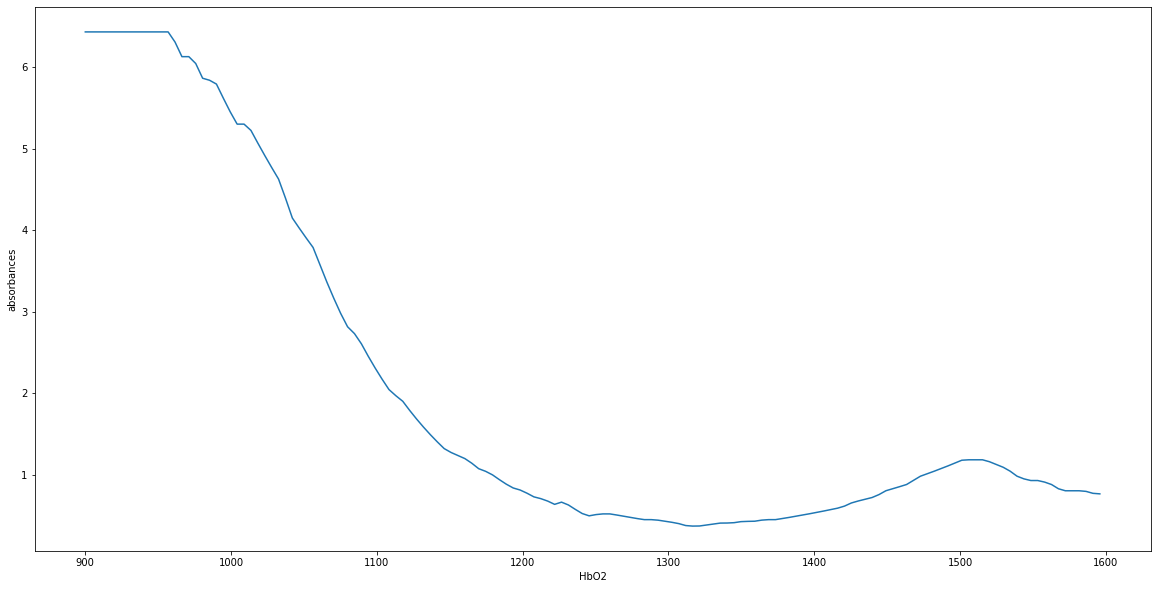

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_hgb_02, x = 'HbO2', y = 'absorbances')

In [ ]:
spectra_hgb

,Hb,Unnamed: 1,Unnamed: 2,HbO2,Unnamed: 4
0,(X) Wavelength,(Y)Absorbance Coefficient (cm-1),NaN,(X) Wavelength,(Y)Absorbance Coefficient (cm-1)
1,900,4.014902471,NaN,900,6.432784461
2,904.733704,4.138519444,NaN,904.733704,6.432784461
3,909.467468,4.163159021,NaN,909.467468,6.432784461
4,914.201172,4.163159021,NaN,914.201172,6.432784461
...,...,...,...,...,...
144,1576.923096,0.603585781,NaN,1576.923096,0.804473977
145,1581.65686,0.601905068,NaN,1581.65686,0.804473977
146,1586.390503,0.590561322,NaN,1586.390503,0.796858115
147,1591.124268,0.555808264,NaN,1591.124268,0.77305608


In [ ]:
# #Hb
spectra_hgb = spectra_hgb[['Hb', 'Unnamed: 1']]

spectra_hgb = spectra_hgb.rename(columns = {'Unnamed: 1' : 'absorbances'})

In [ ]:
spectra_hgb= spectra_hgb[1:]

In [ ]:
spectra_hgb['Hb'] = spectra_hgb['Hb'].astype(float)
spectra_hgb['absorbances'] = spectra_hgb['absorbances'].astype(float)

**Spectral signature of Hb**

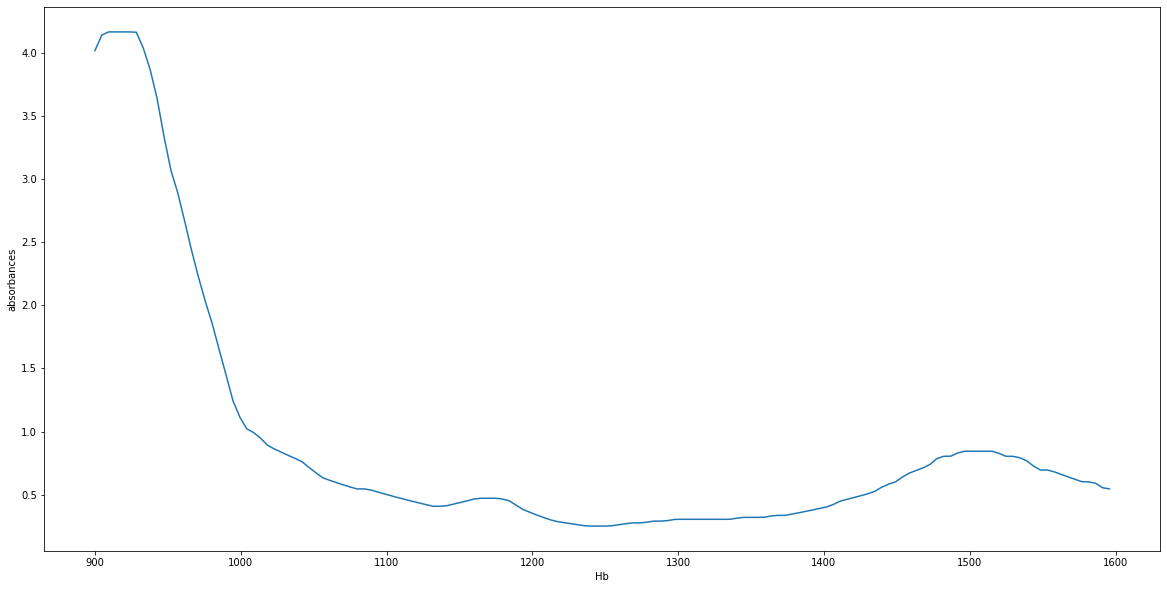

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_hgb, x = 'Hb', y = 'absorbances')

**VISUALIZATION OF SPECTRAL SIGNATURES OF BLOODS AI SPECTROSCOPY DATA**

**Selecting a high hemoglobin levels train example and comparing spectral signature**

In [ ]:
spectra_hgb['Hgb_high_1'] = list(all_data[all_data['hemoglobin(hgb)_human'] == 'high'].iloc[0][1:149].values)

spectra_hgb['Hgb_high_2'] = list(all_data[all_data['hemoglobin(hgb)_human'] == 'high'].iloc[100][1:149].values)

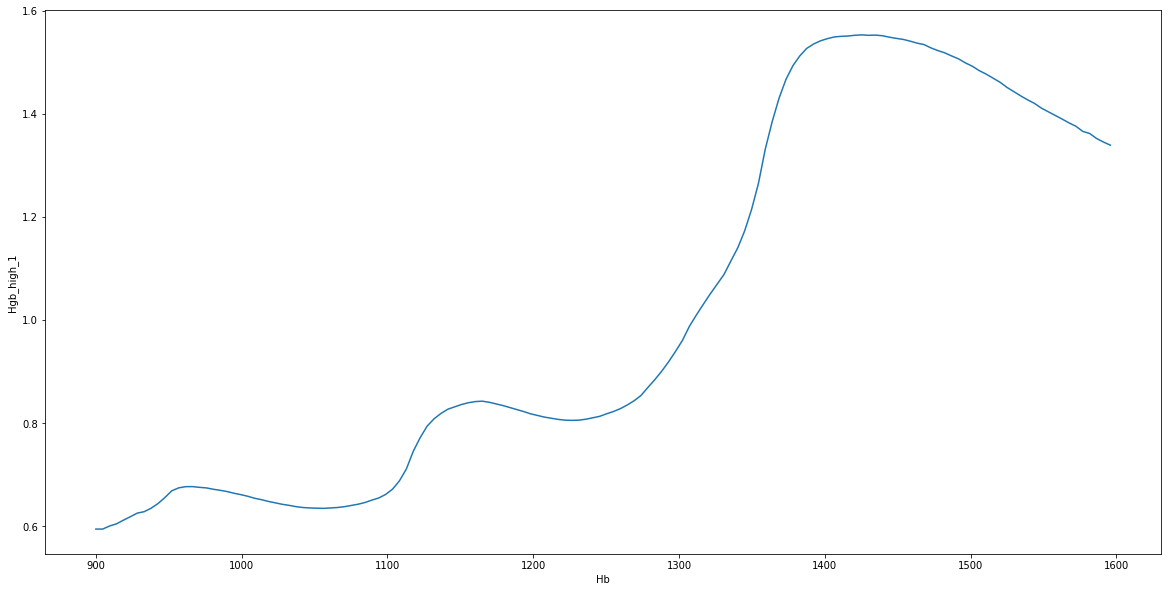

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_hgb, x = 'Hb', y = 'Hgb_high_1')

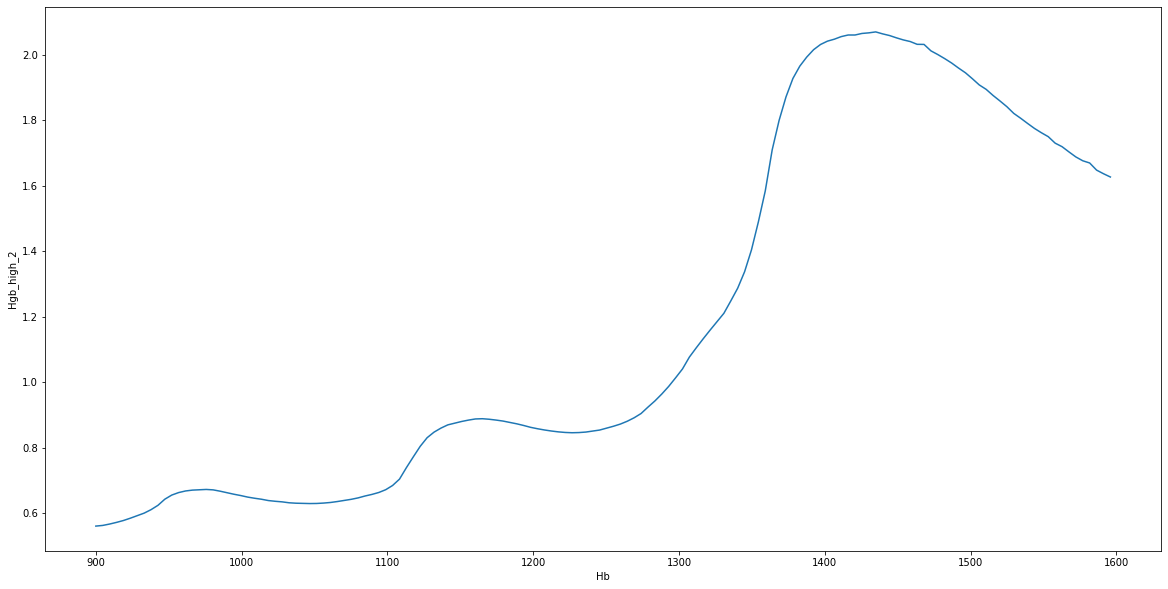

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_hgb, x = 'Hb', y = 'Hgb_high_2')

**Selecting a low hemoglobin levels train example and comparing spectral signature**

In [ ]:
spectra_hgb['Hgb_low_1'] = list(all_data[all_data['hemoglobin(hgb)_human'] == 'low'].iloc[0][1:149].values)

spectra_hgb['Hgb_low_2'] = list(all_data[all_data['hemoglobin(hgb)_human'] == 'low'].iloc[100][1:149].values)

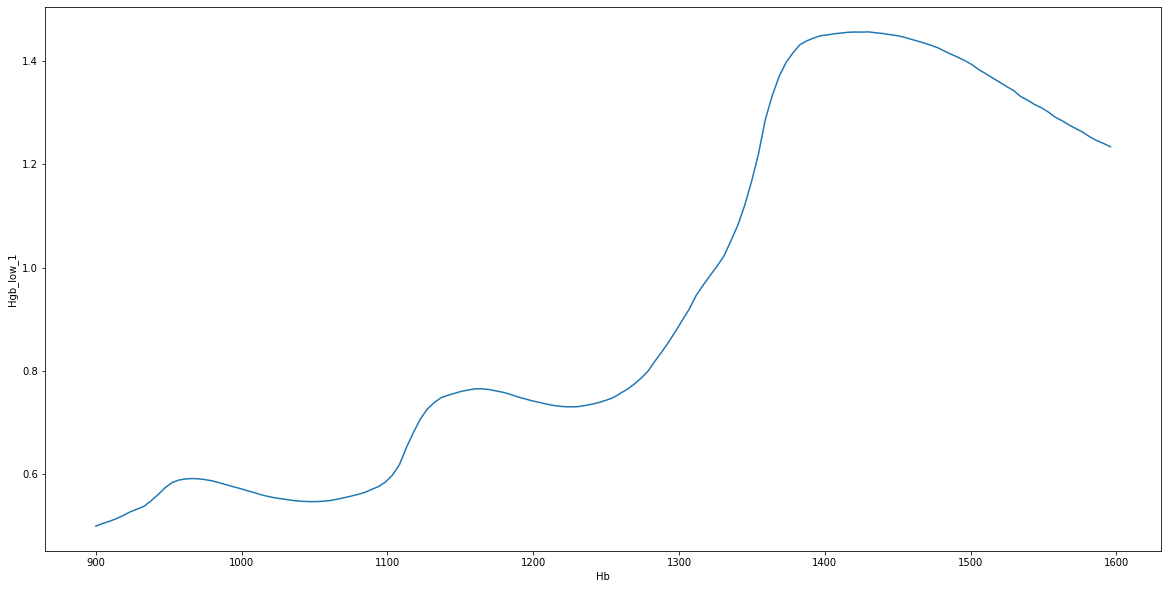

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_hgb, x = 'Hb', y = 'Hgb_low_1')

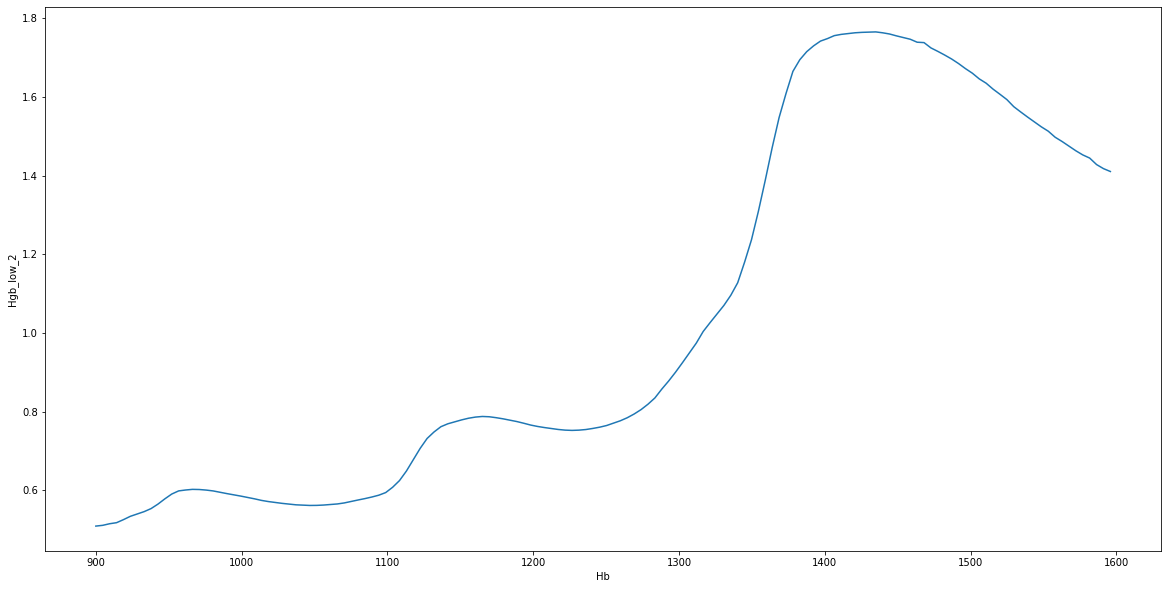

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_hgb, x = 'Hb', y = 'Hgb_low_2')

**Selecting a ok hemoglobin levels train example and comparing spectral signature**

In [ ]:
spectra_hgb['Hgb_ok_1'] = list(all_data[all_data['hemoglobin(hgb)_human'] == 'ok'].iloc[0][1:149].values)

spectra_hgb['Hgb_ok_2'] = list(all_data[all_data['hemoglobin(hgb)_human'] == 'ok'].iloc[100][1:149].values)

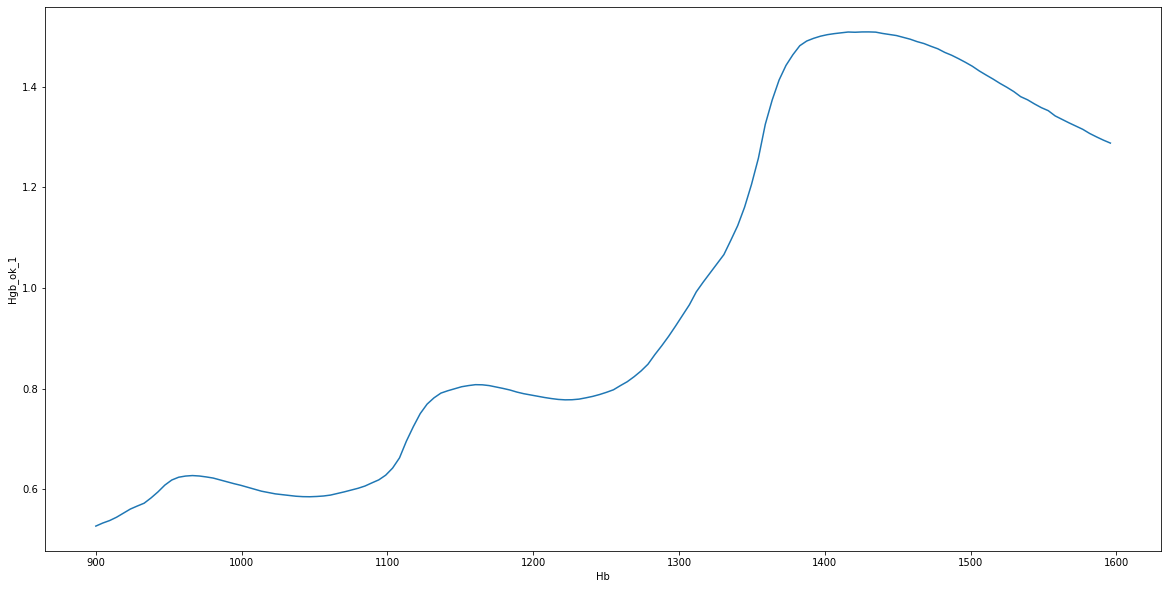

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_hgb, x = 'Hb', y = 'Hgb_ok_1')

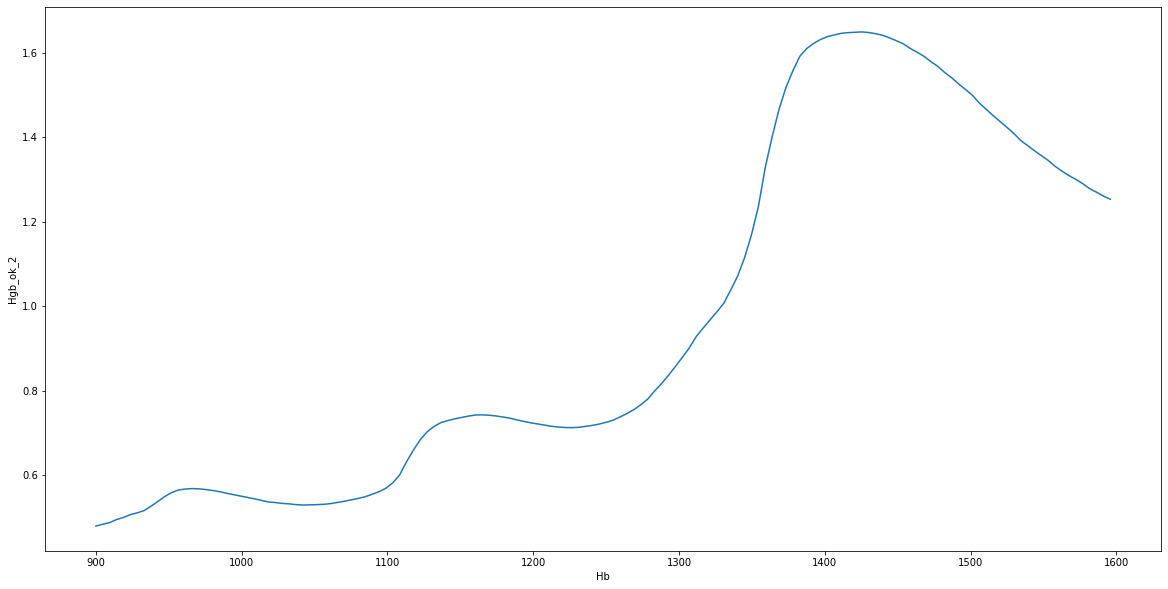

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_hgb, x = 'Hb', y = 'Hgb_ok_2')

Examining the spectra signatures for ok, low, high. We notice very minute details between the 1350-1500 wavelength range. Possibly a CNN can extract classifier can extract this minute detail for prediction. Low shows smoother line signature and smoothness transitions to roughess as levels move from low to high.

**CHL**

In [ ]:
spectra_chl.head()

,Cholesterol,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(X) Wavelength,(Y)Absorbance Coefficient (cm-1),NaN,NaN,NaN,NaN,NaN
1,900,0.176311646,NaN,NaN,NaN,NaN,NaN
2,904.733704,0.176035801,NaN,NaN,NaN,NaN,NaN
3,909.467468,0.175760387,NaN,NaN,NaN,NaN,NaN
4,914.201172,0.175485404,NaN,NaN,NaN,NaN,NaN


In [ ]:
spectra_chl = spectra_chl[['Cholesterol', 'Unnamed: 1']]

spectra_chl = spectra_chl.rename(columns = {'Unnamed: 1' : 'absorbances'})

In [ ]:
spectra_chl.head()

,Cholesterol,absorbances
0,(X) Wavelength,(Y)Absorbance Coefficient (cm-1)
1,900,0.176311646
2,904.733704,0.176035801
3,909.467468,0.175760387
4,914.201172,0.175485404


In [ ]:
spectra_chl = spectra_chl[1:]

In [ ]:
spectra_chl['Cholesterol'] = spectra_chl['Cholesterol'].astype(float)
spectra_chl['absorbances'] = spectra_chl['absorbances'].astype(float)

**Spectral signature of Chl**

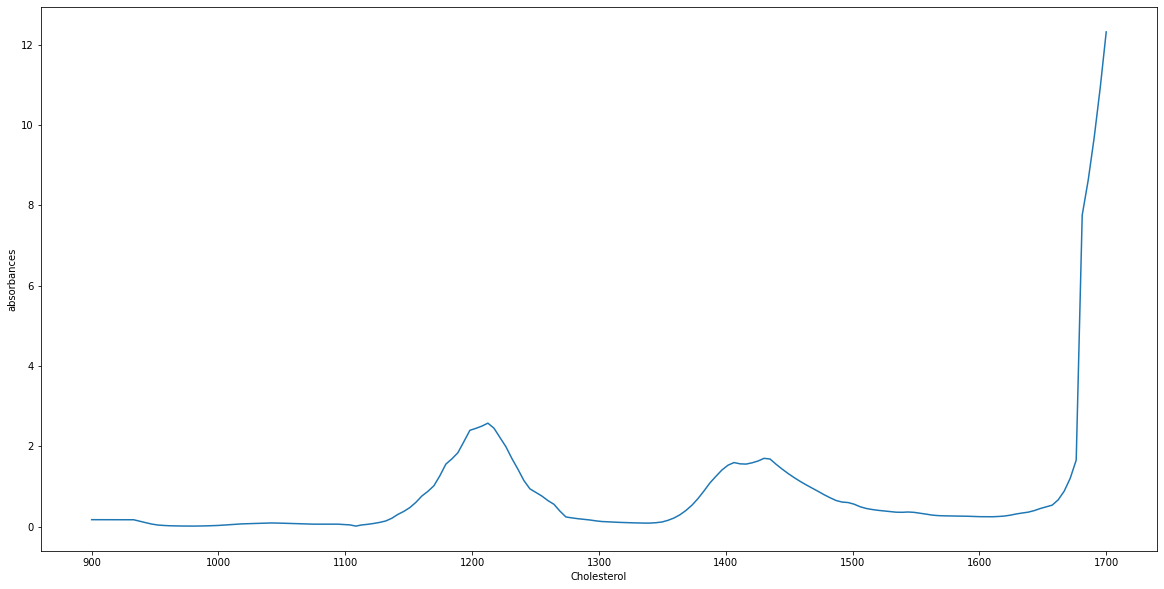

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_chl, x = 'Cholesterol', y = 'absorbances')

**Selecting a high Cholesterol levels train example and comparing spectral signature**

In [ ]:
all_data.columns

Index(['donation_id', 'absorbance0', 'absorbance1', 'absorbance2',
       'absorbance3', 'absorbance4', 'absorbance5', 'absorbance6',
       'absorbance7', 'absorbance8',
       ...
       'absorbance168', 'absorbance169', 'temperature', 'humidity',
       'hdl_cholesterol_human', 'hemoglobin(hgb)_human',
       'cholesterol_ldl_human', 'std', 'tag', 'tag_set'],
      dtype='object', length=179)

In [ ]:
spectra_chl['Chl_high_1'] = list(all_data[all_data['hdl_cholesterol_human'] == 'high'].iloc[0][1:171].values)

spectra_chl['Chl_high_2'] = list(all_data[all_data['hdl_cholesterol_human'] == 'high'].iloc[10][1:171].values)

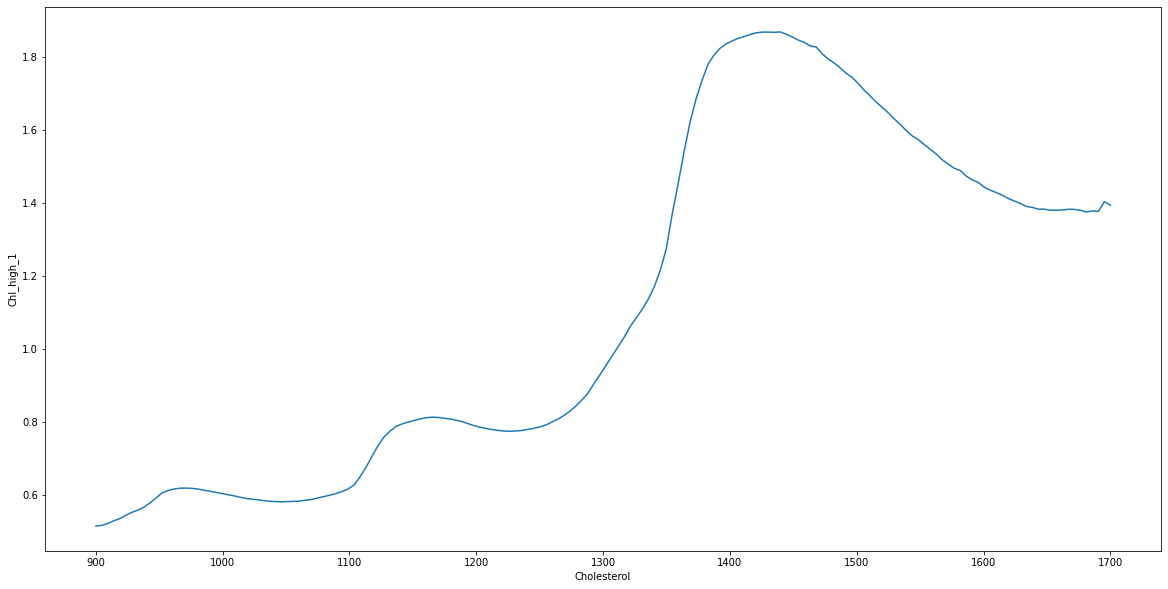

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_chl, x = 'Cholesterol', y = 'Chl_high_1')

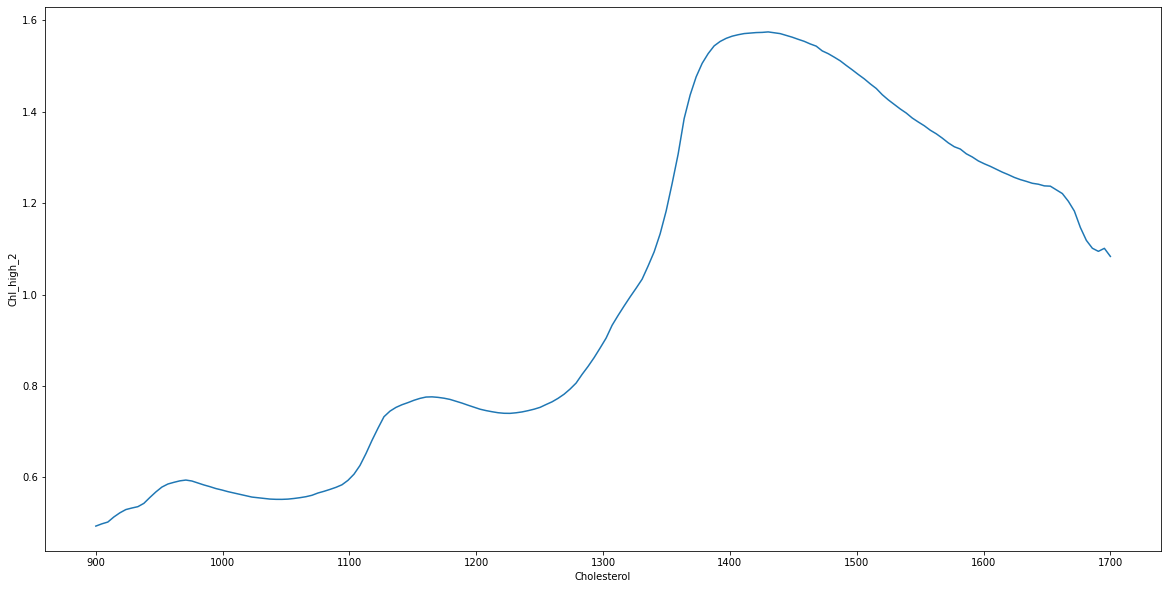

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_chl, x = 'Cholesterol', y = 'Chl_high_2')

**Selecting a low Cholesterol levels train example and comparing spectral signature**

In [ ]:
spectra_chl['Chl_low_1'] = list(all_data[all_data['hdl_cholesterol_human'] == 'low'].iloc[0][1:171].values)

spectra_chl['Chl_low_2'] = list(all_data[all_data['hdl_cholesterol_human'] == 'low'].iloc[100][1:171].values)

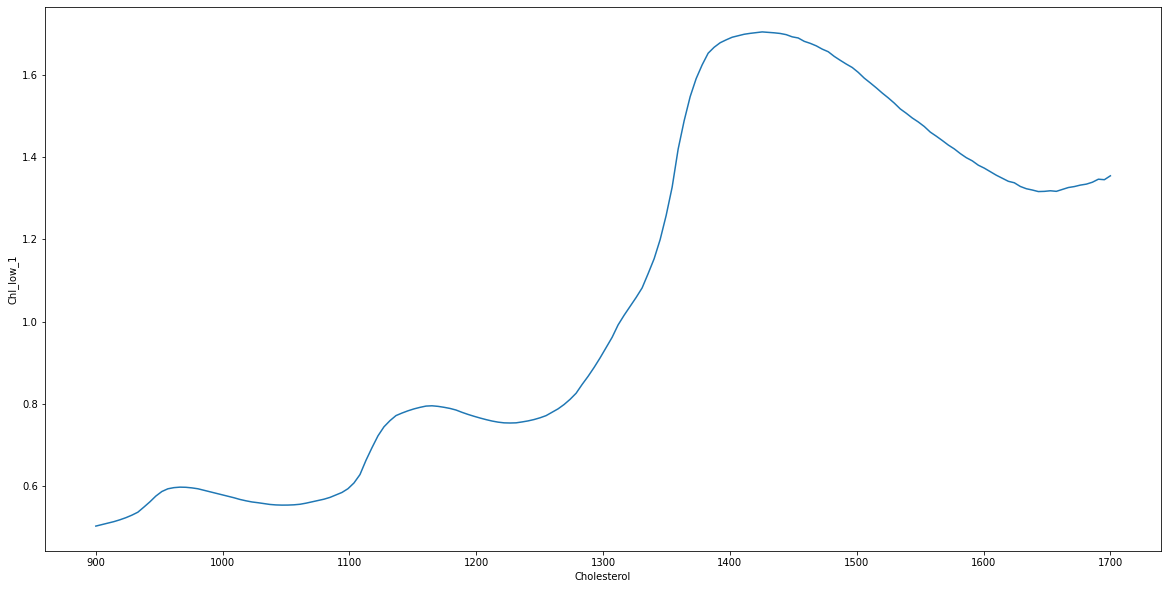

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_chl, x = 'Cholesterol', y = 'Chl_low_1')

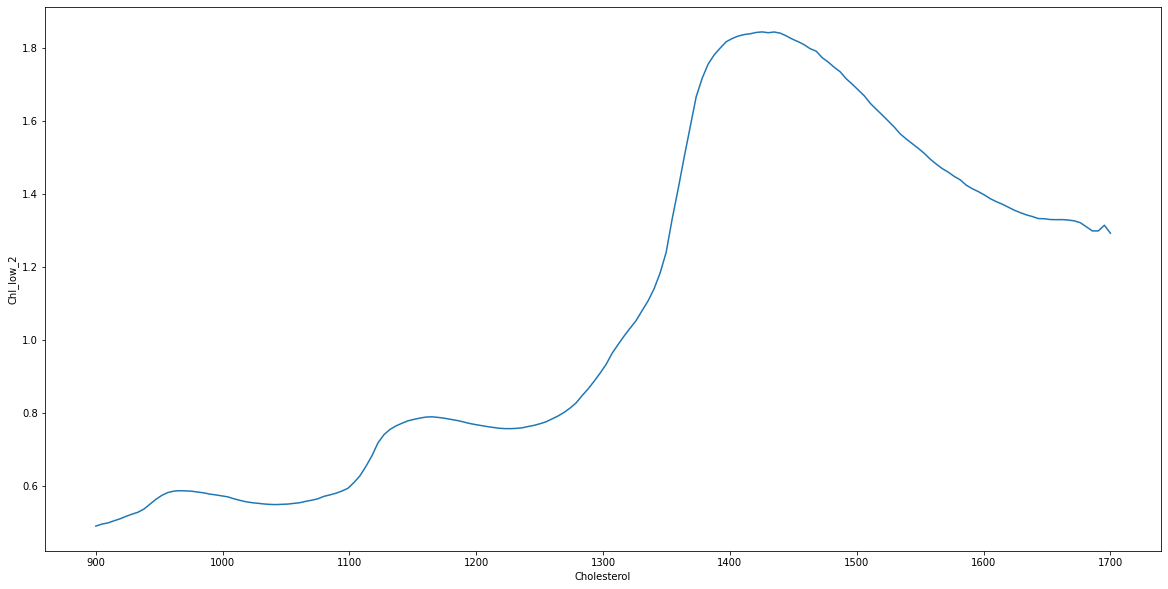

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_chl, x = 'Cholesterol', y = 'Chl_low_2')

Very rare differences in shape of spectra signature to the human eyes. Check whether a relative difference between low and high to the spectral signature from research gives a different relative difference for lower compounds versus presence of higher levels of compound.

**Spectral Signature of Skinfatblood**

In [ ]:
spectra_sknfatbl.head()

,Skin,Unnamed: 1,Unnamed: 2,Fat,Unnamed: 4,Unnamed: 5,Deoxygenated whole blood,Unnamed: 7
0,(X) Wavelength,(Y)Absorbance Coefficient (cm-1),NaN,(X) Wavelength,(Y)Absorbance Coefficient (cm-1),NaN,(X) Wavelength,(Y)Absorbance Coefficient (cm-1)
1,900,4.174649324,NaN,900,5.995811903,NaN,900,18.17079798
2,904.733704,4.143239133,NaN,904.733704,5.995811903,NaN,904.733704,18.17079798
3,909.467468,4.143239133,NaN,909.467468,5.995811903,NaN,909.467468,18.17079798
4,914.201172,4.143239133,NaN,914.201172,5.995811903,NaN,914.201172,18.17079798


In [ ]:
#Skn
spectra_skn = spectra_sknfatbl[['Skin', 'Unnamed: 1']]

spectra_skn = spectra_skn.rename(columns = {'Unnamed: 1' : 'absorbances'})

In [ ]:
spectra_skn = spectra_skn[1:]

In [ ]:
spectra_skn.head()

,Skin,absorbances
1,900,4.174649324
2,904.733704,4.143239133
3,909.467468,4.143239133
4,914.201172,4.143239133
5,918.934937,4.143239133


In [ ]:
spectra_skn['Skin'] = spectra_skn['Skin'].astype(float)
spectra_skn['absorbances'] = spectra_skn['absorbances'].astype(float)

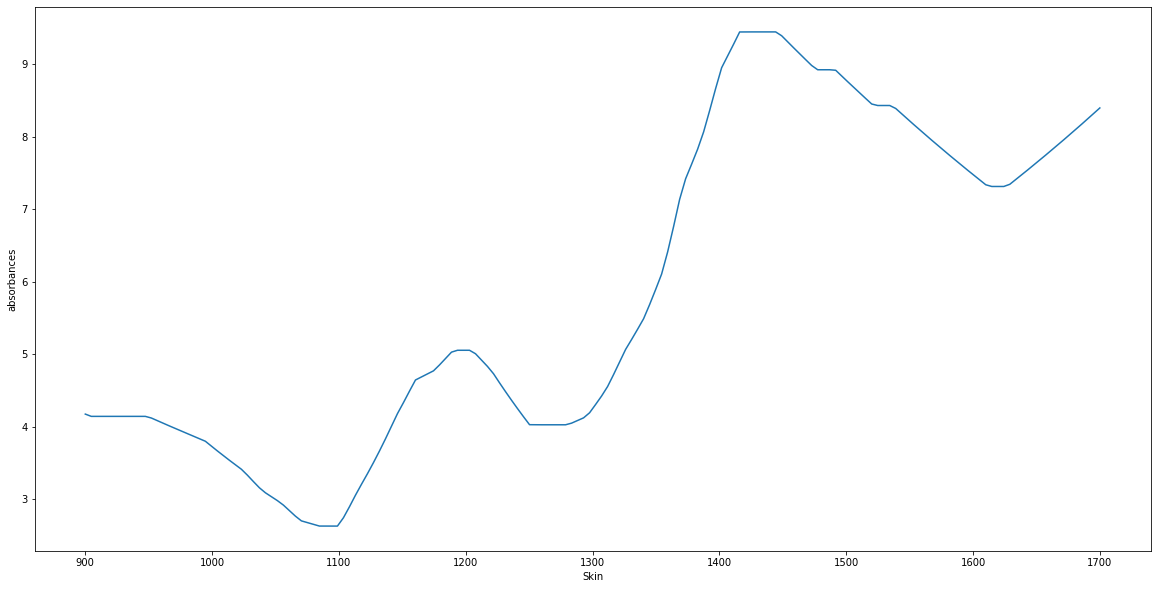

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_skn, x = 'Skin', y = 'absorbances')

In [ ]:
#Fat
spectra_fat = spectra_sknfatbl[['Fat', 'Unnamed: 4']]

spectra_fat = spectra_fat.rename(columns = {'Unnamed: 4' : 'absorbances'})

In [ ]:
spectra_fat = spectra_fat[1:]

In [ ]:
spectra_fat.head()

,Fat,absorbances
1,900,5.995811903
2,904.733704,5.995811903
3,909.467468,5.995811903
4,914.201172,5.995811903
5,918.934937,5.995811903


In [ ]:
spectra_fat['Fat'] = spectra_fat['Fat'].astype(float)
spectra_fat['absorbances'] = spectra_fat['absorbances'].astype(float)

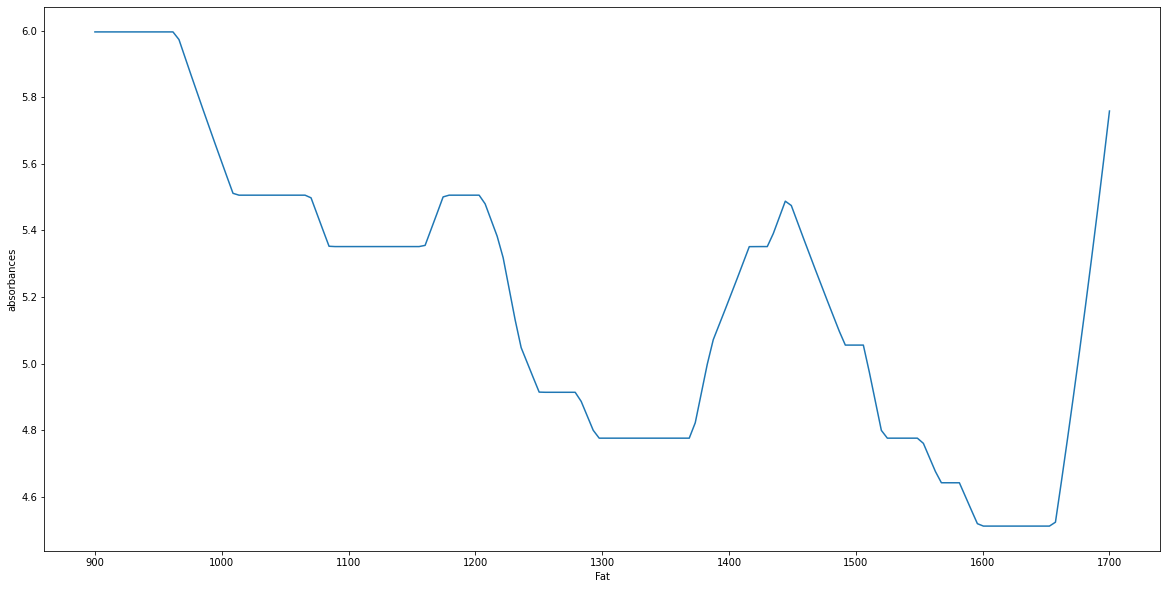

In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = spectra_fat, x = 'Fat', y = 'absorbances')

In [ ]:
#Deoxygenated whole blood
spectra_bl = spectra_sknfatbl[['Deoxygenated whole blood', 'Unnamed: 7']]

spectra_bl = spectra_bl.rename(columns = {'Unnamed: 7' : 'absorbances'})

In [ ]:
spectra_bl = spectra_bl[1:]

In [ ]:
spectra_bl['Deoxygenated whole blood'] = spectra_bl['Deoxygenated whole blood'].astype(float)
spectra_bl['absorbances'] = spectra_bl['absorbances'].astype(float)

In [ ]:
# Rename to uniform Wavelengths names

spectra_hgb = spectra_hgb.rename(columns = {'Hb' : 'wavelengths'})

spectra_hgb_02 = spectra_hgb_02.rename(columns = {'HbO2' : 'wavelengths'})

spectra_chl = spectra_chl.rename(columns = {'Cholesterol' : 'wavelengths'})

spectra_skn = spectra_skn.rename(columns = {'Skin' : 'wavelengths'})

spectra_fat = spectra_fat.rename(columns = {'Fat' : 'wavelengths'})

spectra_bl = spectra_bl.rename(columns = {'Deoxygenated whole blood' : 'wavelengths'})

In [ ]:
from sklearn.metrics import mean_squared_error

**HGB**

In [ ]:
mean_squared_error(spectra_hgb['absorbances'], spectra_hgb['Hgb_high_1'])

1.4069646623458758

In [ ]:
mean_squared_error(spectra_hgb['absorbances'], spectra_hgb['Hgb_high_2'])

1.772516983468205

In [ ]:
mean_squared_error(spectra_hgb['absorbances'], spectra_hgb['Hgb_ok_1'])

1.4141753940460424

In [ ]:
mean_squared_error(spectra_hgb['absorbances'], spectra_hgb['Hgb_ok_2'])

1.479871346944722

In [ ]:
mean_squared_error(spectra_hgb['absorbances'], spectra_hgb['Hgb_low_2'])

1.5587504274626727

In [ ]:
mean_squared_error(spectra_hgb['absorbances'], spectra_hgb['Hgb_low_1'])

1.3962590498329246

**HDL CHOLESTOROL**

In [ ]:
mean_squared_error(spectra_chl['absorbances'], spectra_chl['Chl_high_1'])

2.8981408615953805

In [ ]:
mean_squared_error(spectra_chl['absorbances'], spectra_chl['Chl_high_2'])

2.9041093896054444

In [ ]:
mean_squared_error(spectra_chl['absorbances'], spectra_chl['Chl_low_1'])

2.847354612809519

In [ ]:
mean_squared_error(spectra_chl['absorbances'], spectra_chl['Chl_low_2'])

2.9013917600933143

**Create new features on the compounds composition**

In [ ]:
def calculate_mse_compounds(df, comp, span):
    
    cols = all_data.columns[1:span]
    
    df_span = df[cols].values
    
    return mean_squared_error(df_span, comp['absorbances'])
    
    

In [ ]:
import gc
gc.collect()

522

In [ ]:
all_data['spectra_hgb_delta']= all_data.progress_apply(calculate_mse_compounds, args= [spectra_hgb, 149], axis = 1)

all_data['spectra_hgb02_delta']= all_data.progress_apply(calculate_mse_compounds, args= [spectra_hgb_02, 149], axis = 1)

all_data['spectra_chl_delta']= all_data.progress_apply(calculate_mse_compounds, args= [spectra_chl, 171], axis = 1)

all_data['spectra_skn_delta']= all_data.progress_apply(calculate_mse_compounds, args= [spectra_skn, 171], axis = 1)

all_data['spectra_fat_delta']= all_data.progress_apply(calculate_mse_compounds, args= [spectra_fat, 171], axis = 1)

all_data['spectra_bl_delta']= all_data.progress_apply(calculate_mse_compounds, args= [spectra_bl, 171], axis = 1)

100%|██████████| 4586/4586 [00:03<00:00, 1261.81it/s]


In [ ]:
all_data.head()

,donation_id,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,std,tag,tag_set,spectra_hgb_delta,spectra_hgb02_delta,spectra_chl_delta,spectra_skn_delta,spectra_fat_delta,spectra_bl_delta
0,1964,0.526904,0.532947,0.537904,0.544488,0.552531,0.560754,0.566722,0.572376,0.582886,0.594782,0.608357,0.618430,0.623990,0.626313,0.627283,0.626414,0.624572,0.622358,0.618590,0.614809,0.611248,0.607929,0.604020,0.600325,0.596241,0.593501,0.590939,0.589320,0.587749,0.586229,0.585402,0.585192,0.585742,0.586712,0.588511,0.591611,0.594908,0.598432,0.602040,...,1.306975,1.300110,1.293655,1.287862,1.282877,1.275810,1.270961,1.265257,1.260003,1.255407,1.249608,1.246719,1.242506,1.241202,1.239499,1.236941,1.236321,1.234460,1.225861,1.213503,1.193163,1.163551,1.141981,1.127506,1.122305,1.129030,48.127667,31.377833,NaN,ok,NaN,0.0116,NaN,train,1.414175,6.673970,2.884705,27.110266,17.991274,764.197605
1,1974,0.502636,0.506272,0.509749,0.513453,0.517903,0.523063,0.529182,0.536420,0.548779,0.561564,0.575721,0.586788,0.593362,0.596183,0.597379,0.597024,0.595595,0.593441,0.589847,0.586106,0.582547,0.579195,0.575281,0.571633,0.567467,0.564186,0.561363,0.559531,0.557348,0.555292,0.554136,0.553674,0.553774,0.554391,0.555741,0.558362,0.561581,0.564734,0.568066,...,1.408947,1.398971,1.391246,1.380703,1.373523,1.364866,1.356306,1.349041,1.341526,1.337908,1.328931,1.323439,1.320287,1.316534,1.317011,1.318466,1.317068,1.321710,1.326348,1.328706,1.332262,1.334621,1.339219,1.346593,1.345408,1.354871,38.923333,41.545167,low,NaN,NaN,0.0055,NaN,train,1.534955,6.837619,2.847355,26.314755,17.666044,759.596410
2,1975,0.505055,0.506570,0.511544,0.516300,0.524067,0.530191,0.536138,0.542317,0.551118,0.567411,0.582043,0.594632,0.601357,0.606002,0.610174,0.610535,0.607241,0.602593,0.598158,0.594082,0.589946,0.586214,0.582763,0.579071,0.576070,0.572933,0.569674,0.567799,0.566049,0.564866,0.564235,0.563938,0.564077,0.565843,0.567793,0.570145,0.573502,0.578465,0.583251,...,1.531069,1.514383,1.502906,1.490929,1.480540,1.471343,1.463302,1.453560,1.445046,1.434967,1.428055,1.423711,1.417191,1.414312,1.410027,1.409971,1.410790,1.410953,1.410468,1.409675,1.401169,1.395687,1.390813,1.384304,1.395545,1.369307,42.332500,37.773000,low,ok,ok,0.0073,original_train,train,1.677831,6.930785,2.939031,25.357167,17.131336,754.076888
3,1977,0.499745,0.504864,0.509131,0.514254,0.520526,0.527448,0.532662,0.538192,0.548794,0.560372,0.573590,0.583638,0.588816,0.591043,0.591813,0.591184,0.589313,0.586942,0.583296,0.579456,0.575619,0.572191,0.568113,0.564378,0.560179,0.556985,0.554327,0.552325,0.550453,0.548677,0.547633,0.547155,0.547150,0.547957,0.549293,0.551894,0.554734,0.557808,0.561125,...,1.253625,1.246242,1.240666,1.234321,1.228402,1.221528,1.215301,1.209780,1.205552,1.200282,1.194961,1.191379,1.187049,1.185264,1.184344,1.182709,1.181411,1.179260,1.172881,1.163377,1.150157,1.130407,1.115037,1.106172,1.107999,1.111043,44.429333,34.645500,NaN,low,NaN,0.0054,NaN,train,1.396259,6.745626,2.859093,27.557235,18.357247,766.292070
4,1978,0.502500,0.508453,0.513316,0.519122,0.525631,0.532620,0.537446,0.541617,0.550272,0.

**Create additional statistics about absorbances**

In [ ]:
absorbance_dict.keys()

dict_keys(['absorbance0', 'absorbance1', 'absorbance2', 'absorbance3', 'absorbance4', 'absorbance5', 'absorbance6', 'absorbance7', 'absorbance8', 'absorbance9', 'absorbance10', 'absorbance11', 'absorbance12', 'absorbance13', 'absorbance14', 'absorbance15', 'absorbance16', 'absorbance17', 'absorbance18', 'absorbance19', 'absorbance20', 'absorbance21', 'absorbance22', 'absorbance23', 'absorbance24', 'absorbance25', 'absorbance26', 'absorbance27', 'absorbance28', 'absorbance29', 'absorbance30', 'absorbance31', 'absorbance32', 'absorbance33', 'absorbance34', 'absorbance35', 'absorbance36', 'absorbance37', 'absorbance38', 'absorbance39', 'absorbance40', 'absorbance41', 'absorbance42', 'absorbance43', 'absorbance44', 'absorbance45', 'absorbance46', 'absorbance47', 'absorbance48', 'absorbance49', 'absorbance50', 'absorbance51', 'absorbance52', 'absorbance53', 'absorbance54', 'absorbance55', 'absorbance56', 'absorbance57', 'absorbance58', 'absorbance59', 'absorbance60', 'absorbance61', 'absorb

In [ ]:
all_data['low_abs'] = all_data[list(absorbance_dict.keys())].min(axis = 1)

all_data['high_abs'] = all_data[list(absorbance_dict.keys())].max(axis = 1)

all_data['med_abs'] = all_data[list(absorbance_dict.keys())].median(axis = 1)

all_data['mean_abs'] = all_data[list(absorbance_dict.keys())].mean(axis = 1)

all_data['std_abs'] = all_data[list(absorbance_dict.keys())].std(axis = 1)

all_data['sum_abs'] = all_data[list(absorbance_dict.keys())].sum(axis = 1)

In [ ]:
all_data.head()

,donation_id,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,std,tag,tag_set,spectra_hgb_delta,spectra_hgb02_delta,spectra_chl_delta,spectra_skn_delta,spectra_fat_delta,spectra_bl_delta,low_abs,high_abs,med_abs,mean_abs,std_abs,sum_abs
0,1964,0.526904,0.532947,0.537904,0.544488,0.552531,0.560754,0.566722,0.572376,0.582886,0.594782,0.608357,0.618430,0.623990,0.626313,0.627283,0.626414,0.624572,0.622358,0.618590,0.614809,0.611248,0.607929,0.604020,0.600325,0.596241,0.593501,0.590939,0.589320,0.587749,0.586229,0.585402,0.585192,0.585742,0.586712,0.588511,0.591611,0.594908,0.598432,0.602040,...,1.270961,1.265257,1.260003,1.255407,1.249608,1.246719,1.242506,1.241202,1.239499,1.236941,1.236321,1.234460,1.225861,1.213503,1.193163,1.163551,1.141981,1.127506,1.122305,1.129030,48.127667,31.377833,NaN,ok,NaN,0.0116,NaN,train,1.414175,6.673970,2.884705,27.110266,17.991274,764.197605,0.526904,1.508755,0.934972,1.008824,0.343625,171.500045
1,1974,0.502636,0.506272,0.509749,0.513453,0.517903,0.523063,0.529182,0.536420,0.548779,0.561564,0.575721,0.586788,0.593362,0.596183,0.597379,0.597024,0.595595,0.593441,0.589847,0.586106,0.582547,0.579195,0.575281,0.571633,0.567467,0.564186,0.561363,0.559531,0.557348,0.555292,0.554136,0.553674,0.553774,0.554391,0.555741,0.558362,0.561581,0.564734,0.568066,...,1.356306,1.349041,1.341526,1.337908,1.328931,1.323439,1.320287,1.316534,1.317011,1.318466,1.317068,1.321710,1.326348,1.328706,1.332262,1.334621,1.339219,1.346593,1.345408,1.354871,38.923333,41.545167,low,NaN,NaN,0.0055,NaN,train,1.534955,6.837619,2.847355,26.314755,17.666044,759.596410,0.502636,1.704966,0.924308,1.058958,0.426846,180.022936
2,1975,0.505055,0.506570,0.511544,0.516300,0.524067,0.530191,0.536138,0.542317,0.551118,0.567411,0.582043,0.594632,0.601357,0.606002,0.610174,0.610535,0.607241,0.602593,0.598158,0.594082,0.589946,0.586214,0.582763,0.579071,0.576070,0.572933,0.569674,0.567799,0.566049,0.564866,0.564235,0.563938,0.564077,0.565843,0.567793,0.570145,0.573502,0.578465,0.583251,...,1.463302,1.453560,1.445046,1.434967,1.428055,1.423711,1.417191,1.414312,1.410027,1.409971,1.410790,1.410953,1.410468,1.409675,1.401169,1.395687,1.390813,1.384304,1.395545,1.369307,42.332500,37.773000,low,ok,ok,0.0073,original_train,train,1.677831,6.930785,2.939031,25.357167,17.131336,754.076888,0.505055,1.927817,0.958842,1.135224,0.497048,192.988096
3,1977,0.499745,0.504864,0.509131,0.514254,0.520526,0.527448,0.532662,0.538192,0.548794,0.560372,0.573590,0.583638,0.588816,0.591043,0.591813,0.591184,0.589313,0.586942,0.583296,0.579456,0.575619,0.572191,0.568113,0.564378,0.560179,0.556985,0.554327,0.552325,0.550453,0.548677,0.547633,0.547155,0.547150,0.547957,0.549293,0.551894,0.554734,0.557808,0.561125,...,1.215301,1.209780,1.205552,1.200282,1.194961,1.191379,1.187049,1.185264,1.184344,1.182709,1.181411,1.179260,1.172881,1.163377,1.150157,1.130407,1.115037,1.106172,1.107999,1.111043,44.429333,34.645500,NaN,low,NaN,0.0054,NaN,train,1.396259,6.745626,2.859093,27.557235,18.357247,766.292070,0.499745,1.456600,0.887890,0.964364,0.338796,163.941795
4,1978,0.502500,0.508453,0.513316,0.519122,0.525631,0.532620,0.537446,0.541617,0.550272,0.560281,0.572091,0.581120,0

In [ ]:
all_data.columns[100:]

Index(['absorbance99', 'absorbance100', 'absorbance101', 'absorbance102',
       'absorbance103', 'absorbance104', 'absorbance105', 'absorbance106',
       'absorbance107', 'absorbance108', 'absorbance109', 'absorbance110',
       'absorbance111', 'absorbance112', 'absorbance113', 'absorbance114',
       'absorbance115', 'absorbance116', 'absorbance117', 'absorbance118',
       'absorbance119', 'absorbance120', 'absorbance121', 'absorbance122',
       'absorbance123', 'absorbance124', 'absorbance125', 'absorbance126',
       'absorbance127', 'absorbance128', 'absorbance129', 'absorbance130',
       'absorbance131', 'absorbance132', 'absorbance133', 'absorbance134',
       'absorbance135', 'absorbance136', 'absorbance137', 'absorbance138',
       'absorbance139', 'absorbance140', 'absorbance141', 'absorbance142',
       'absorbance143', 'absorbance144', 'absorbance145', 'absorbance146',
       'absorbance147', 'absorbance148', 'absorbance149', 'absorbance150',
       'absorbance151', 'a

In [ ]:
all_data.groupby(['hdl_cholesterol_human'])['med_abs'].mean()

hdl_cholesterol_human
high    0.903731
low     0.921763
ok      0.916294
Name: med_abs, dtype: float64

In [ ]:
all_data.groupby(['cholesterol_ldl_human'])['med_abs'].mean()

cholesterol_ldl_human
high    0.915714
low     0.921976
ok      0.913852
Name: med_abs, dtype: float64

In [ ]:
all_data.groupby(['hemoglobin(hgb)_human'])['med_abs'].mean()

hemoglobin(hgb)_human
high    0.901040
low     0.882311
ok      0.893322
Name: med_abs, dtype: float64

In [ ]:
all_data["hdl_cholesterol_human"]

0       NaN
1       low
2       low
3       NaN
4       NaN
       ... 
4581    NaN
4582    NaN
4583    NaN
4584    NaN
4585    NaN
Name: hdl_cholesterol_human, Length: 4586, dtype: object

### Target Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


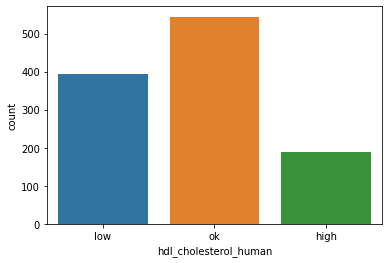

In [ ]:
sns.countplot(all_data["hdl_cholesterol_human"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


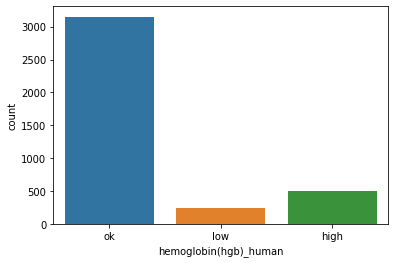

In [ ]:
sns.countplot(all_data["hemoglobin(hgb)_human"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


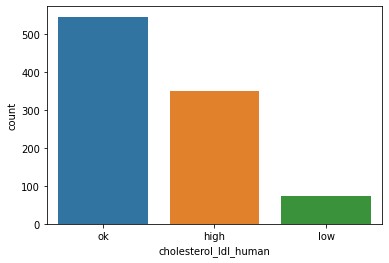

In [ ]:
sns.countplot(all_data["cholesterol_ldl_human"])

In [ ]:
all_data.columns

Index(['donation_id', 'absorbance0', 'absorbance1', 'absorbance2',
       'absorbance3', 'absorbance4', 'absorbance5', 'absorbance6',
       'absorbance7', 'absorbance8',
       ...
       'spectra_chl_delta', 'spectra_skn_delta', 'spectra_fat_delta',
       'spectra_bl_delta', 'low_abs', 'high_abs', 'med_abs', 'mean_abs',
       'std_abs', 'sum_abs'],
      dtype='object', length=191)

**BASELINE MODELLING**

In [ ]:
#Create uniform mapping

mapping = {'low' : '0', 'ok' : '1', 'high' : '2'}

reverse_mapping = {'0' : 'low', '1' : 'ok', '2' : 'high'}

all_data['hdl_cholesterol_human'] = all_data['hdl_cholesterol_human'].replace(mapping)

all_data['hemoglobin(hgb)_human'] = all_data['hemoglobin(hgb)_human'].replace(mapping)

all_data['cholesterol_ldl_human'] = all_data['cholesterol_ldl_human'].replace(mapping)

**Method 1- Build using individual samples of donation id**

In [ ]:
#Extract categorical

cat_cols = []

for col in all_data.columns:
    
    if all_data[col].dtype == 'O':
        
        cat_cols.append(col)

In [ ]:
cat_cols.remove('tag')
cat_cols.remove('tag_set')
cat_cols.remove('donation_id')
#cat_cols.remove('Reading_ID')
cat_cols.remove('hdl_cholesterol_human')
cat_cols.remove('hemoglobin(hgb)_human')
cat_cols.remove('cholesterol_ldl_human')

In [ ]:
all_data.isnull().sum()

donation_id    0
absorbance0    0
absorbance1    0
absorbance2    0
absorbance3    0
              ..
high_abs       0
med_abs        0
mean_abs       0
std_abs        0
sum_abs        0
Length: 191, dtype: int64

In [ ]:
train = all_data[all_data['tag_set'] == 'train']

test = all_data[all_data['tag_set'] == 'test']


train = train.drop(['tag_set'], axis = 1)

test = test.drop(['tag_set'], axis = 1)

In [ ]:
train.shape, test.shape

((4525, 190), (61, 190))

In [ ]:
train.reset_index(drop = True, inplace = True)

test.reset_index(drop = True, inplace = True)

In [ ]:
train = train.sample(random_state = 40, frac = 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train = scaler.fit(train)
test = scaler.transform(test)

ValueError: ignored

In [ ]:
train.head()

,donation_id,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,std,tag,spectra_hgb_delta,spectra_hgb02_delta,spectra_chl_delta,spectra_skn_delta,spectra_fat_delta,spectra_bl_delta,low_abs,high_abs,med_abs,mean_abs,std_abs,sum_abs
3718,10212,0.556596,0.558302,0.561071,0.566317,0.574298,0.581964,0.585634,0.589441,0.594615,0.603936,0.613876,0.622134,0.627365,0.629705,0.630898,0.630428,0.628534,0.626505,0.623892,0.620577,0.617530,0.615030,0.612002,0.609287,0.606181,0.603356,0.601715,0.599789,0.598774,0.597708,0.597443,0.597687,0.597821,0.598766,0.600777,0.602784,0.605361,0.609225,0.612979,...,1.264542,1.258188,1.252000,1.246167,1.239100,1.234475,1.230165,1.226078,1.221754,1.219550,1.217255,1.214982,1.210251,1.200931,1.184803,1.162118,1.130773,1.108940,1.095144,1.098625,1.092214,47.638000,39.588000,NaN,1,NaN,0.0082,NaN,1.407376,6.648983,2.902462,27.093174,17.980276,763.859137,0.556596,1.536260,0.916301,1.009575,0.345767,171.627707
4147,11106,0.542763,0.541754,0.548041,0.552668,0.562241,0.569496,0.573994,0.576949,0.582819,0.591926,0.603394,0.614989,0.619235,0.620973,0.620583,0.618655,0.615005,0.610777,0.607248,0.604470,0.601420,0.598380,0.595404,0.591202,0.588899,0.585523,0.583276,0.581656,0.580274,0.578387,0.578012,0.577859,0.578298,0.579559,0.580607,0.583809,0.586791,0.590431,0.594490,...,1.471985,1.461646,1.452516,1.444284,1.435471,1.425490,1.419688,1.413562,1.408218,1.405837,1.405458,1.400734,1.400729,1.393667,1.377779,1.358693,1.330942,1.301377,1.289802,1.305742,1.287181,49.162667,38.607000,NaN,1,NaN,0.0065,NaN,1.651324,6.874206,2.983174,25.391845,17.133782,754.061263,0.541754,1.927299,0.941726,1.133467,0.491665,192.689448
2501,7451,0.503179,0.504539,0.509427,0.513513,0.521016,0.529294,0.537206,0.541146,0.547213,0.556795,0.568125,0.578618,0.585842,0.588089,0.589042,0.588910,0.587860,0.586053,0.582957,0.580416,0.577640,0.574735,0.572191,0.567848,0.564577,0.561579,0.559245,0.557311,0.555790,0.554090,0.553704,0.553411,0.553987,0.554845,0.556807,0.559541,0.562344,0.565816,0.569582,...,1.306001,1.300250,1.294224,1.287215,1.280876,1.276013,1.272691,1.267837,1.263742,1.260919,1.256534,1.250505,1.240716,1.225963,1.206945,1.190159,1.176803,1.173779,1.180127,1.198944,1.196452,42.033833,36.070000,NaN,1,NaN,0.0048,NaN,1.459129,6.786763,2.870911,26.957172,18.035242,762.953725,0.503179,1.581167,0.891418,1.008519,0.383716,171.448171
1538,5582,0.586416,0.588145,0.592493,0.598840,0.605599,0.618563,0.622770,0.624869,0.629120,0.638259,0.650778,0.664443,0.670131,0.673878,0.675009,0.675306,0.673544,0.670480,0.667975,0.664757,0.661081,0.658397,0.655342,0.651479,0.648349,0.646476,0.643764,0.641695,0.640259,0.639039,0.637823,0.637346,0.637599,0.637940,0.639236,0.640903,0.644004,0.646885,0.650500,...,1.409151,1.403066,1.395767,1.390089,1.382924,1.379515,1.372176,1.368869,1.365007,1.364472,1.363380,1.362794,1.358798,1.352524,1.337747,1.318776,1.300670,1.282472,1.274766,1.271638,1.273789,45.251833,21.973833,NaN,1,NaN,0.0154,NaN,1.482795,6.613653,2.910486,26.093349,17.314753,758.976247,0.586416,1.662719,0.972366,1.096515,0.388052,186.407587
430,3157,0.433893,0.434595,0.437553,0.441142,0.455345,0.471442,0.473857,0.473451,0.478909,0.488741,0

**Build each model individually**

In [ ]:
#Cross-Validation LGBM routine

def lgb_crossval(model, X, y, added_train, added_target):

    rand = 40

    fold = StratifiedKFold(n_splits= 5, shuffle= True, random_state= rand)
    

    i = 1

    acc_bin = list()
    
    
    predictions = []
    
    
    X_cols = list(X.columns)
    
    X_len = len(X_cols)
    
    
    
    test_new = test[X_cols]
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X_len)

    


    for train_index, test_index in fold.split(X, y):
        
    
        print('fold n°: ', i)
        

        x_data, x_val = X.iloc[train_index], X.iloc[test_index]

        y_data, y_val = y.iloc[train_index], y.iloc[test_index]
    
    
        x_data = pd.concat([x_data, added_train])
        
        y_data = pd.concat([y_data, added_target])
   
        
        model.fit(x_data, y_data, eval_set= [(x_val, y_val)], verbose = 100,
                  early_stopping_rounds = 200)
        
    
        y_train_pred = model.predict(x_data)
        
        y_test_pred = model.predict(x_val)
        
        test_pred = model.predict(test_new)
        
        test_pred= test_pred.tolist()

        
        
        feature_importances += model.feature_importances_ 
    

    
        print('accuracy train', accuracy_score(y_data, y_train_pred))
        print('accuracy test',  accuracy_score(y_val, y_test_pred))
    
    
    
        
        
        acc_bin.append(accuracy_score(y_val, y_test_pred))
        
        predictions.append(test_pred)
    
    


        i = i + 1
        
    print('Mean acc bin test: ', np.mean(acc_bin)) 
    
    
    return feature_importances/10, acc_bin, predictions

In [ ]:
def create_model(group):
    
    groups =['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']
    
    groups.remove(group)
    
    train_group = train[train[group].isnull() == False]
    
    train_group = train_group.drop(groups, axis = 1)
    
    
    #Selecting only original train for validation

    original_train = train_group[train_group['tag'] == 'original_train']

    added_train = train_group[train_group['tag'] != 'original_train']
    
    
    
    y = original_train[group]
    added_target = added_train[group]
    
    
    drops = ['donation_id', 'tag', group]
    X = original_train.drop(drops, axis = 1)
    added_train = added_train.drop(drops, axis = 1)
    
    
    importances, auc_scores, test_group = lgb_crossval(lgb_model_1, X, y, added_train, added_target)
    
    return importances, auc_scores, test_group

    

**1) cholesterol_ldl_human**

In [ ]:
%time
lgb_model_1 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.004, 
                               boosting = 'gbdt', importance_type = 'gain',\
                           random_state = 40,  num_leaves = 60, 
                            objective = 'multiclass', metric = 'multi_error', \
                            first_metric_only = True, \
                            feature_fraction = 0.8)

importances, auc_scores, test_chl_ldl = create_model('cholesterol_ldl_human')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
fold n°:  1
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_error: 0.463918
[200]	valid_0's multi_error: 0.463918
[300]	valid_0's multi_error: 0.443299
[400]	valid_0's multi_error: 0.443299
Early stopping, best iteration is:
[265]	valid_0's multi_error: 0.43299
accuracy train 0.8048220436280138
accuracy test 0.5670103092783505
fold n°:  2
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_error: 0.463918
[200]	valid_0's multi_error: 0.463918
Early stopping, best iteration is:
[90]	valid_0's multi_error: 0.453608
accuracy train 0.5809414466130884
accuracy test 0.5463917525773195
fold n°:  3
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_error: 0.453608
[200]	valid_0's multi_error: 0.453608
[300]	valid_0's multi_error: 0.463918
[400]	valid_0's multi_error: 0.453608
Early stopping, best iteration is:
[202]	valid_0's mu

In [ ]:
# feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': importances}).sort_values('importance', 
#                                     ascending = True)
    

In [ ]:
# feature_importances[-20:]

In [ ]:
import scipy

In [ ]:
test['cholesterol_ldl_human'] = list(scipy.stats.mode(np.array(test_chl_ldl))[0][0])

In [ ]:
test['cholesterol_ldl_human'] = test['cholesterol_ldl_human'].replace(reverse_mapping)

In [ ]:
test['cholesterol_ldl_human'].value_counts()

ok      56
high     5
Name: cholesterol_ldl_human, dtype: int64

**2) hdl_cholesterol_human**

In [ ]:
%time
lgb_model_1 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.004, 
                               boosting = 'gbdt', importance_type = 'gain',\
                           random_state = 40,  num_leaves = 60, 
                            objective = 'multiclass', metric = 'multi_error', \
                            first_metric_only = True, feature_fraction = 0.8)

importances, auc_scores, test_chl_hdl = create_model('hdl_cholesterol_human')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
fold n°:  1
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_error: 0.474227
[200]	valid_0's multi_error: 0.463918
[300]	valid_0's multi_error: 0.474227
Early stopping, best iteration is:
[158]	valid_0's multi_error: 0.453608
accuracy train 0.7227626459143969
accuracy test 0.5463917525773195
fold n°:  2
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_error: 0.484536
[200]	valid_0's multi_error: 0.536082
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.484536
accuracy train 0.4805447470817121
accuracy test 0.5154639175257731
fold n°:  3
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_error: 0.505155
[200]	valid_0's multi_error: 0.494845
[300]	valid_0's multi_error: 0.515464
Early stopping, best iteration is:
[175]	valid_0's multi_error: 0.484536
accuracy train 0.7198443579766537
accuracy test 0.515463

In [ ]:
test['hdl_cholesterol_human'] = list(scipy.stats.mode(np.array(test_chl_hdl))[0][0])

In [ ]:
test['hdl_cholesterol_human'] = test['hdl_cholesterol_human'].replace(reverse_mapping)

In [ ]:
test['hdl_cholesterol_human'].value_counts()

ok    61
Name: hdl_cholesterol_human, dtype: int64

**3) hemoglobin(hgb)_human**

In [ ]:
%time
lgb_model_1 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.004, 
                               boosting = 'gbdt', importance_type = 'gain',\
                           random_state = 40,  num_leaves = 60, 
                            objective = 'multiclass', metric = 'multi_error', \
                            first_metric_only = True)

importances, auc_scores, test_hgb = create_model('hemoglobin(hgb)_human')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
fold n°:  1
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_error: 0.14433
[200]	valid_0's multi_error: 0.14433
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.14433
accuracy train 0.8071560115759011
accuracy test 0.8556701030927835
fold n°:  2
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_error: 0.154639
[200]	valid_0's multi_error: 0.154639
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.154639
accuracy train 0.8074191002367798
accuracy test 0.845360824742268
fold n°:  3
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_error: 0.154639
[200]	valid_0's multi_error: 0.154639
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.154639
accuracy train 0.8074191002367798
accuracy test 0.845360824742268
fold n°:  4
Training until validation scores don't improve for 200 rounds.

In [ ]:
test['hemoglobin(hgb)_human'] = list(scipy.stats.mode(np.array(test_chl_hdl))[0][0])

In [ ]:
test['hemoglobin(hgb)_human'] = test['hemoglobin(hgb)_human'].replace(reverse_mapping)

In [ ]:
test['hemoglobin(hgb)_human'].value_counts()

ok    61
Name: hemoglobin(hgb)_human, dtype: int64

In [ ]:
test

,donation_id,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,std,tag,spectra_hgb_delta,spectra_hgb02_delta,spectra_chl_delta,spectra_skn_delta,spectra_fat_delta,spectra_bl_delta,low_abs,high_abs,med_abs,mean_abs,std_abs,sum_abs
0,ID_1961,0.499920,0.504608,0.507929,0.519943,0.529032,0.536118,0.539690,0.541710,0.548590,0.560742,0.572227,0.582468,0.588715,0.591515,0.594874,0.596132,0.593921,0.589298,0.584735,0.580726,0.576208,0.573006,0.569422,0.566248,0.563401,0.560530,0.557530,0.556048,0.554297,0.553283,0.553039,0.552928,0.553576,0.555021,0.556709,0.559042,0.562160,0.567039,0.570653,...,1.248585,1.242906,1.237545,1.231696,1.225090,1.220767,1.214857,1.210767,1.208588,1.204434,1.200936,1.195675,1.185186,1.165124,1.140465,1.098607,1.065527,1.044592,1.035440,1.041868,1.027759,41.507000,40.839333,ok,ok,ok,0.0064,NaN,1.431546,6.764039,2.918611,27.285713,18.207689,764.525129,0.499920,1.545996,0.890386,0.984720,0.361753,167.402402
1,ID_2067,0.497758,0.498091,0.503083,0.507249,0.513739,0.521944,0.528798,0.533743,0.541470,0.551838,0.563810,0.576655,0.582322,0.585335,0.587424,0.588745,0.588792,0.586696,0.584191,0.581720,0.579240,0.576917,0.573680,0.570807,0.567496,0.564498,0.562600,0.560363,0.558279,0.557036,0.555625,0.554756,0.554074,0.554820,0.555545,0.557092,0.559098,0.562553,0.565149,...,1.260009,1.254758,1.247724,1.241378,1.236482,1.229732,1.225451,1.223462,1.218626,1.218425,1.217652,1.216998,1.218545,1.221584,1.221688,1.221872,1.219100,1.221694,1.221569,1.233970,1.227104,42.656500,39.675167,ok,ok,ok,0.0038,NaN,1.436178,6.776204,2.824341,27.167728,18.171850,763.984252,0.497758,1.561147,0.868207,0.989850,0.372864,168.274451
2,ID_2155,0.551436,0.553079,0.556722,0.560722,0.565583,0.570889,0.578668,0.585142,0.594233,0.610121,0.624801,0.637173,0.645108,0.649101,0.650867,0.651125,0.649180,0.647096,0.644185,0.640608,0.637902,0.635386,0.631675,0.625593,0.621151,0.616636,0.613757,0.610795,0.608635,0.607679,0.606690,0.606639,0.606520,0.608730,0.611250,0.614201,0.617529,0.621660,0.627568,...,1.464195,1.456410,1.449595,1.442547,1.436186,1.430327,1.426222,1.421095,1.415937,1.416552,1.414947,1.412894,1.416760,1.419018,1.422387,1.421566,1.422355,1.423502,1.433594,1.451166,1.433315,42.523833,41.728500,ok,ok,ok,0.0043,NaN,1.598017,6.764593,2.890061,25.492891,17.047161,755.549498,0.551436,1.815660,1.001062,1.138021,0.446924,193.463542
3,ID_2211,0.525926,0.528948,0.532222,0.540022,0.547279,0.554348,0.558680,0.563768,0.570031,0.583540,0.596124,0.607093,0.613002,0.616624,0.619543,0.620841,0.618805,0.614166,0.610156,0.605965,0.601668,0.598687,0.595476,0.592006,0.589363,0.586510,0.583951,0.582185,0.580720,0.579559,0.578678,0.578325,0.579207,0.580438,0.581965,0.584198,0.587096,0.591386,0.595273,...,1.328247,1.320609,1.312814,1.306433,1.298607,1.291746,1.287399,1.283340,1.279884,1.276867,1.275387,1.273222,1.271094,1.264453,1.251708,1.234305,1.212873,1.203968,1.196735,1.201349,1.192471,40.505833,43.938667,ok,ok,ok,0.0046,NaN,1.536177,6.790401,2.918499,26.298052,17.611214,759.037196,0.525926,1.778915,0.920952,1.063624,0.424112,180.816128
4,ID_2327,0.559814,0.559612,0.561561,0.565162,0.567556,0.572362,0.579762,0.587761,0.599415,0.615964,0.6306

In [ ]:
test.columns[150:]

Index(['absorbance149', 'absorbance150', 'absorbance151', 'absorbance152',
       'absorbance153', 'absorbance154', 'absorbance155', 'absorbance156',
       'absorbance157', 'absorbance158', 'absorbance159', 'absorbance160',
       'absorbance161', 'absorbance162', 'absorbance163', 'absorbance164',
       'absorbance165', 'absorbance166', 'absorbance167', 'absorbance168',
       'absorbance169', 'temperature', 'humidity', 'hdl_cholesterol_human',
       'hemoglobin(hgb)_human', 'cholesterol_ldl_human', 'std', 'tag',
       'spectra_hgb_delta', 'spectra_hgb02_delta', 'spectra_chl_delta',
       'spectra_skn_delta', 'spectra_fat_delta', 'spectra_bl_delta', 'low_abs',
       'high_abs', 'med_abs', 'mean_abs', 'std_abs', 'sum_abs'],
      dtype='object')

#### -  Convert our submission as per the sample submission 

In [ ]:
ss

,Unnamed: 0,Donation_ID,target
0,0,ID_1961_cholesterol_ldl_human,ok
1,1,ID_1961_hdl_cholesterol_human,ok
2,2,ID_1961_hemoglobin(hgb)_human,ok
3,3,ID_2067_cholesterol_ldl_human,ok
4,4,ID_2067_hdl_cholesterol_human,ok
...,...,...,...
178,178,ID_7755_hdl_cholesterol_human,ok
179,179,ID_7755_hemoglobin(hgb)_human,ok
180,180,ID_7821_cholesterol_ldl_human,ok
181,181,ID_7821_hdl_cholesterol_human,ok


In [ ]:
def transform_c_hdl(row):
    return pd.Series([str(row["donation_id"]) + "_hdl_cholesterol_human", row['hdl_cholesterol_human']])

In [ ]:
sample_c_hdl = pd.DataFrame(columns = ss.columns)

In [ ]:
sample_c_hdl[['Donation_ID', 'target']] = test.progress_apply(transform_c_hdl, axis = 1)

100%|██████████| 61/61 [00:00<00:00, 2258.27it/s]


In [ ]:
def transform_hemo(row):
    return pd.Series([str(row["donation_id"]) + "_hemoglobin(hgb)_human", row["hemoglobin(hgb)_human"]])

In [ ]:
sample_hemo = pd.DataFrame(columns = ss.columns)

In [ ]:
sample_hemo[['Donation_ID', 'target']] = test.progress_apply(transform_hemo, axis = 1)

100%|██████████| 61/61 [00:00<00:00, 3584.57it/s]


In [ ]:
def transform_c_ldl(row):
    return pd.Series([str(row["donation_id"]) + "_cholesterol_ldl_human", row["cholesterol_ldl_human"]])

In [ ]:
sample_c_ldl = pd.DataFrame(columns = ss.columns)

In [ ]:
sample_c_ldl[['Donation_ID', 'target']] = test.progress_apply(transform_c_ldl, axis = 1)

100%|██████████| 61/61 [00:00<00:00, 2340.83it/s]


In [ ]:
submission = pd.concat([sample_c_hdl, sample_hemo, sample_c_ldl]).reset_index(drop=True)

In [ ]:
submission = submission.loc[:, ~submission.columns.str.contains('^Unnamed')]

In [ ]:
submission.head()

,Donation_ID,target
0,ID_1961_hdl_cholesterol_human,ok
1,ID_2067_hdl_cholesterol_human,ok
2,ID_2155_hdl_cholesterol_human,ok
3,ID_2211_hdl_cholesterol_human,ok
4,ID_2327_hdl_cholesterol_human,ok


In [ ]:
submission

,Donation_ID,target
0,ID_1961_hdl_cholesterol_human,ok
1,ID_2067_hdl_cholesterol_human,ok
2,ID_2155_hdl_cholesterol_human,ok
3,ID_2211_hdl_cholesterol_human,ok
4,ID_2327_hdl_cholesterol_human,ok
...,...,...
178,ID_6373_cholesterol_ldl_human,ok
179,ID_6381_cholesterol_ldl_human,ok
180,ID_6391_cholesterol_ldl_human,high
181,ID_7755_cholesterol_ldl_human,ok


In [ ]:
submission.to_csv("./submission.csv", index=False)

### Convolutional Neural Network model